### Note: we utilize the MdrDB database to provide a comprehensive evaluation of the machine learning methods and provide benchmark prediction results.
_____
Baselines: 
Four families of methods were used to evaluate the drug resistance prediction performance:  
- Tree-based methods, including decision tree (DecisionTree), random forest (RandomForest), and extremely randomized regression trees (ExtraTrees). 
- Linear-based methods containing support vector regression (SVR), elastic net linear regression (Elastic Net), and lasso regression (Lasso). 
- Ensemble-based methods including bagging regressor (Bagging), AdaBoost, and gradient boosting (GradienBoost). 
- Neural network-based methods such as multi-layer perceptron (MLP). 

Evaluation metrics: 
- Root Mean Square Error (RMSE)
- Pearson correlation coefficient (Pears)
- Area under the precision-recall curve (AUPRC).
____
We investigated the baseline results of MdrDB in 5 different experimental scenarios.

In [1]:
# import packages
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GroupKFold, LeaveOneGroupOut
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cluster import KMeans

from commons.figureplot import plot_corr
from commons.models import InstantiationModel
from commons.performance import get_rmse, get_pearson, get_auc_roc, get_R2, get_mae, get_auc_prc, cal_performance_groupcv
from commons.utils import log_message, save_obj, load_obj, get_protein_sequence

from rdkit import Chem
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import pandas as pd
import numpy as np
import random
import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
# import dataset
# according to your path to change the coreset_path
coreset_path = "/data1/Project/Resistance_Database/Coscmd/MdrDB_CoreSet_release_v1.0.2022.tsv"

# import MdrDB_Coreset
mdrdb_coreset = pd.read_csv(coreset_path, sep = "\t")

print(f"Number of samples in MdrDBCoreset: {mdrdb_coreset.shape[0]}")
mdrdb_coreset.head()

Number of samples in MdrDBCoreset: 4292


SAMPLE_ID    VERSION DATASET                   TYPE UNIPROT_ID  \
0  MdrDBcore00000  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
1  MdrDBcore00001  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
2  MdrDBcore00002  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
3  MdrDBcore00003  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
4  MdrDBcore00004  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   

     MUTATION           DRUG                                SMILES  \
0  A16C+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   
1  A16C+S108T  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl   
2  A16G+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   
3  A16G+S108T  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl   
4  A16S+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   

  SAMPLE_PDB_ID  DDG.EXP  ... P2dp.P P2dp.N P2dp.DA P2dp.D P2dp.A P2dp.AR  \
0          6A2K     2.42  ...    0.0 -0.640     0.0    0.0  5.425  -0.785   
1          3UM8    -0.41  ...    0.0  1.528     0.0    0.0 -6.215  -0.562   
2          6A2K     2.64  ...    0.0  3.596     0.0    0.0  1.706  -3.122   
3          6A2K     0.31  ...    0.0  1.588     0.0    0.0  1.820  -3.930   
4          6A2K     3.65  ...    0.0 -0.500     0.0    0.0  6.204  -3.214   

  P2dp.H P2dp.PL P2dp.HA P2dp.SA  
0  1.728  -3.165     0.0   2.558  
1  4.638   4.448     0.0   3.835  
2  2.176   4.510     0.0   8.858  
3 -3.077   9.027     0.0   5.428  
4  1.724   1.322     0.0   5.536  

[5 rows x 167 columns]

In [3]:
# Setting global variable
models_list = ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'GradientBoost', 'SVR', 'ElasticNet', 'Lasso', 'MLP']
save_file = True    # options: True, False
iterations = 5      # repetition times
n_fold = 5          # k-fold cross-validation

### Scenario 1: Evaluate the prediction performance of the machine learning methods on the MdrDB_Coreset, which samples belonging to single substitution.
____
#### Scenario 1.1: Randomly split the samples (single substitution). 
Approximately 80% of the data became training samples, and the remaining 20% were test samples.

In [4]:
# Select single substitution samples
mut_type = "Single Substitution"
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_single.shape[0]}")

y = mdrdb_single["DDG.EXP"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_single.drop(todrop, axis=1)
X = X.astype(float)

Number of samples in Single Substitution of MdrDBCoreset: 3697


In [5]:
# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    mae_dict[model] = []
    r2_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    
for iteration in range(iterations):
    # Randomly split the dataset into 80% training data and 20% test data
    seed = random.randint(0, 100)
    np.random.seed(seed)
    log_message(f"random sampling samples with seed {seed}...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Training the model
    for model in models_list:
        log_message(f"---current model is: {model}---")
        method = InstantiationModel(model)
        method.fit(X_train, y_train)
        y_pred = method.predict(X_test)

        # record the predicted results
        col_name = f'{model}_iter_{iteration}'
        result_dict[f"label_iter_{iteration}"] = np.array(y_test.to_list())
        result_dict[col_name] = y_pred
        
        # performance
        RMSE = get_rmse(y_test, y_pred)
        MAE = get_mae(y_test, y_pred)
        R2 = get_R2(y_test, y_pred)
        Pears = get_pearson(y_test, y_pred)
        PRC = get_auc_prc(y_test, y_pred)
               
        log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
               
        rmse_dict[model].append(RMSE)
        mae_dict[model].append(MAE)
        r2_dict[model].append(R2)
        pears_dict[model].append(Pears)
        prc_dict[model].append(PRC)

    log_message(f"Finish the {iteration}-th iteration!")

[2023-04-21 16:58:06] random sampling samples with seed 37...
[2023-04-21 16:58:06] ---current model is: DecisionTree---
[2023-04-21 16:58:06] RMSE: 1.6708; MAE: 1.0597; R2: -0.4569; Pears: 0.2399; PRC: 0.2467
[2023-04-21 16:58:06] ---current model is: RandomForest---
[2023-04-21 16:58:25] RMSE: 1.1792; MAE: 0.7454; R2: 0.2742; Pears: 0.5522; PRC: 0.4569
[2023-04-21 16:58:25] ---current model is: ExtraTrees---
[2023-04-21 16:58:31] RMSE: 1.1311; MAE: 0.7051; R2: 0.3323; Pears: 0.5861; PRC: 0.5076
[2023-04-21 16:58:31] ---current model is: Bagging---
[2023-04-21 16:58:51] RMSE: 1.17; MAE: 0.7437; R2: 0.2856; Pears: 0.5634; PRC: 0.458
[2023-04-21 16:58:51] ---current model is: AdaBoost---
[2023-04-21 16:59:04] RMSE: 1.4641; MAE: 1.0231; R2: -0.1187; Pears: 0.0902; PRC: 0.235
[2023-04-21 16:59:04] ---current model is: GradientBoost---
[2023-04-21 16:59:38] RMSE: 1.1625; MAE: 0.7641; R2: 0.2947; Pears: 0.5453; PRC: 0.4153
[2023-04-21 16:59:38] ---current model is: SVR---
[2023-04-21 16:59:

In [6]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(mae_dict[model]), np.std(mae_dict[model]), 
                            np.mean(r2_dict[model]), np.std(r2_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sotrted = results.sort_values(by='RMSE_avg', ascending=False)
results_sotrted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std  R2_avg  R2_std  \
9            MLP     2.632     1.317    1.480    0.404  -3.491   4.813   
0   DecisionTree     1.650     0.089    1.094    0.025  -0.440   0.140   
4       AdaBoost     1.472     0.085    1.060    0.044  -0.141   0.037   
8          Lasso     1.371     0.090    0.911    0.027   0.013   0.008   
7     ElasticNet     1.368     0.090    0.908    0.027   0.016   0.011   
6            SVR     1.364     0.089    0.902    0.027   0.022   0.009   
5  GradientBoost     1.186     0.068    0.793    0.020   0.260   0.028   
3        Bagging     1.164     0.088    0.762    0.020   0.288   0.022   
1   RandomForest     1.163     0.087    0.761    0.019   0.290   0.025   
2     ExtraTrees     1.139     0.084    0.732    0.019   0.319   0.024   

   Pearson_avg  Pearson_std  AUPRC_avg  AUPRC_std  
9        0.029        0.052      0.198      0.043  
0        0.275        0.044      0.289      0.043  
4        0.145        0.041      0.231      0.034  
8        0.124        0.030      0.237      0.028  
7        0.138        0.032      0.239      0.032  
6        0.155        0.027      0.251      0.032  
5        0.511        0.028      0.391      0.044  
3        0.558        0.020      0.444      0.030  
1        0.560        0.020      0.445      0.031  
2        0.570        0.021      0.488      0.032

In [13]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.1-single_randomsplit_ddG.pkl"
save_perf = "S1.1-single_randomsplit_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sotrted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sotrted

result_ddg_one = {}
result_index = "2"
for method in result_ddg.keys():
    if result_index in method:
        result_ddg_one[method] = result_ddg[method]
result_ddg_one = pd.DataFrame(result_ddg_one)

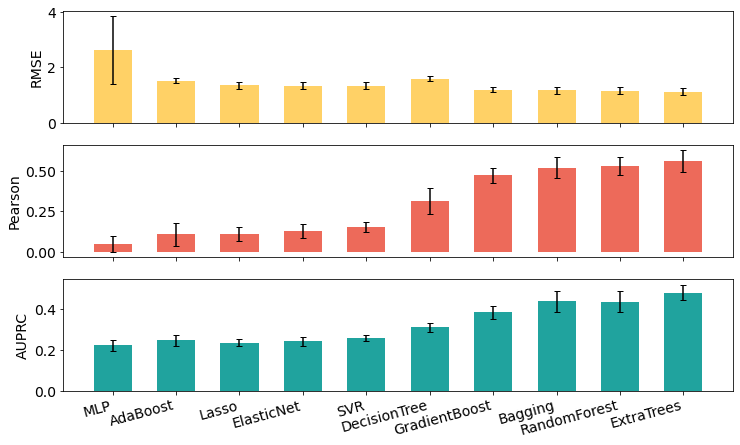

In [14]:
# plot1: bar plot

# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()
auprc = result_perf["AUPRC_avg"].to_list()
auprc_err = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])
auprc_sorted = np.array([auprc[i] for i in sorted_indices])
auprc_err_sorted = np.array([auprc_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.1-single_randomsplit_barplot.pdf"))
plt.show()

In [15]:
# Rename the columns
result_ddg_one.columns = [i.split("_")[0] for i in result_ddg_one.columns]
columns_name = np.insert(x_sorted, 0, "label")

# Reorder the columns
result_ddg_new = result_ddg_one.reindex(columns=columns_name)

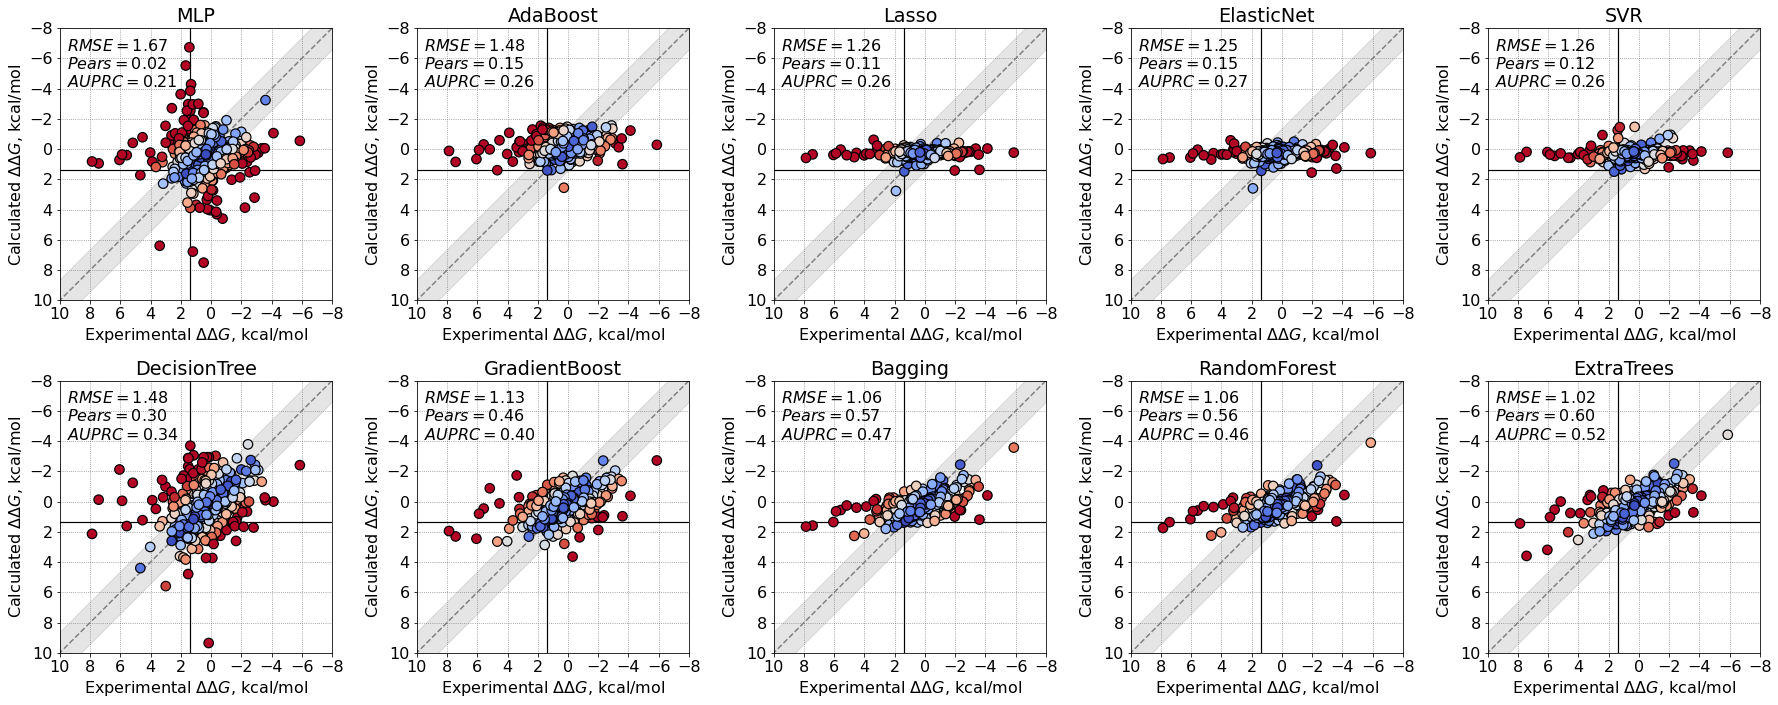

In [16]:
# plot 2. Scatter plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S1.1-single_randomsplit_scattorplot.pdf"))

____
#### Scenario 1.2: 5-fold cross-validation (single substitution).
All data is randomly split into 5 folds, and then the machine learning method is trained on the 4 folds, while one fold is left to test the model. This precedure is repeated 5 times.
____

In [17]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_single.shape[0]}")

y = mdrdb_single["DDG.EXP"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_single.drop(todrop, axis=1)
X = X.astype(float)

Number of samples in Single Substitution of MdrDBCoreset: 3697


In [18]:
# 5-fold cross-validation
result_dict = {}
result_dict['label_true'] = y

# Set the seed for reproducibility
seed = random.randint(0, 100) 
np.random.seed(seed)

# record results
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    
for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model)    
    
    # create a KFold object with 5 folds and set the seed
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
    
    # Perform 5-fold cross validation using RMSE as the metric
    rmse_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_rmse))
    pearson_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_pearson))
    auprc_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_auc_prc))  
    
    result_dict[model] = cross_val_predict(method, X, y, cv=kf)
    
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(rmse_scores.mean()))
    log_message("RMSE standard deviation: {:.2f}".format(rmse_scores.std()))
    
    rmse_dict[model].append(rmse_scores)
    pears_dict[model].append(pearson_scores)
    prc_dict[model].append(auprc_scores)

[2023-04-21 17:07:37] ---current model is: DecisionTree---
[2023-04-21 17:07:45] Mean RMSE score: 1.61
[2023-04-21 17:07:45] RMSE standard deviation: 0.08
[2023-04-21 17:07:45] ---current model is: RandomForest---
[2023-04-21 17:13:45] Mean RMSE score: 1.15
[2023-04-21 17:13:45] RMSE standard deviation: 0.13
[2023-04-21 17:13:45] ---current model is: ExtraTrees---
[2023-04-21 17:15:44] Mean RMSE score: 1.13
[2023-04-21 17:15:44] RMSE standard deviation: 0.15
[2023-04-21 17:15:44] ---current model is: Bagging---
[2023-04-21 17:21:50] Mean RMSE score: 1.15
[2023-04-21 17:21:50] RMSE standard deviation: 0.13
[2023-04-21 17:21:50] ---current model is: AdaBoost---
[2023-04-21 17:25:55] Mean RMSE score: 1.50
[2023-04-21 17:25:55] RMSE standard deviation: 0.14
[2023-04-21 17:25:55] ---current model is: GradientBoost---
[2023-04-21 17:37:16] Mean RMSE score: 1.19
[2023-04-21 17:37:16] RMSE standard deviation: 0.13
[2023-04-21 17:37:16] ---current model is: SVR---
[2023-04-21 17:37:40] Mean RMS

In [19]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sotrted = results.sort_values(by='RMSE_avg', ascending=False)
results_sotrted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
9            MLP     1.951     0.528        0.030        0.034      0.221   
0   DecisionTree     1.608     0.078        0.352        0.101      0.316   
4       AdaBoost     1.501     0.141        0.172        0.102      0.234   
8          Lasso     1.322     0.137        0.114        0.043      0.226   
7     ElasticNet     1.319     0.139        0.132        0.049      0.231   
6            SVR     1.302     0.140        0.203        0.038      0.270   
5  GradientBoost     1.186     0.133        0.480        0.044      0.407   
3        Bagging     1.147     0.131        0.523        0.057      0.467   
1   RandomForest     1.146     0.133        0.523        0.052      0.463   
2     ExtraTrees     1.132     0.146        0.533        0.064      0.487   

   AUPRC_std  
9      0.036  
0      0.012  
4      0.014  
8      0.026  
7      0.022  
6      0.029  
5      0.036  
3      0.046  
1      0.046  
2      0.038

In [20]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.2-single_5foldcv_ddG.pkl"
save_perf = "S1.2-single_5foldcv_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sotrted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sotrted

result_ddg = pd.DataFrame(result_ddg)

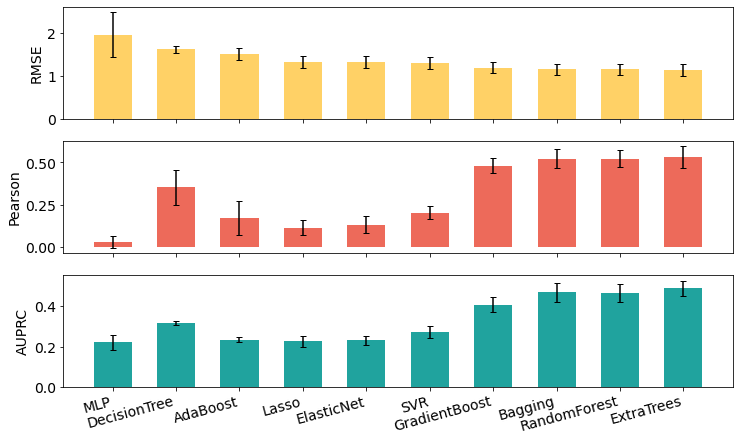

In [21]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()
auprc = result_perf["AUPRC_avg"].to_list()
auprc_err = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])
auprc_sorted = np.array([auprc[i] for i in sorted_indices])
auprc_err_sorted = np.array([auprc_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.2-single_5foldcv_barplot.pdf"))
plt.show()

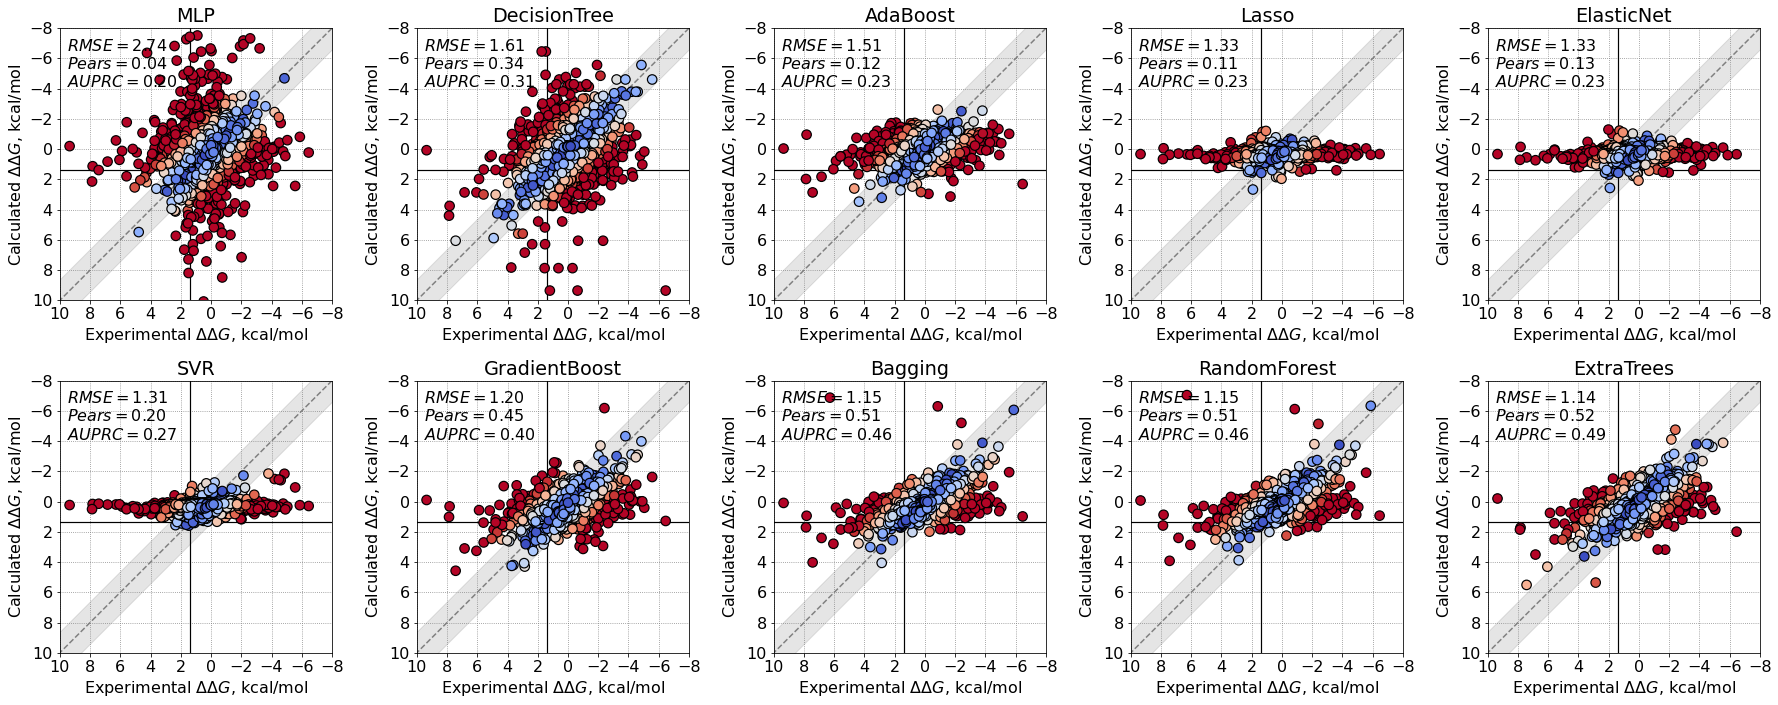

In [22]:
# plot 2. Scatter plot
# Reorder the columns
columns_name = np.insert(x_sorted, 0, "label_true")
result_ddg_new = result_ddg.reindex(columns=columns_name)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.2-single_5foldcv_scatterplot.pdf"))
plt.show()

______
#### Scenario 1.3: Group 5-fold cross-validation (Uniprot ID).
Grouping samples according to Uniprot ID, and all data is randomly divided into 5 folds, where the same group does not appear in two different folds. The machine learning method is trained on the k - 1 folds, while one fold is left to test the method. This process is repeated 5 times to obtain predictions for all data.
______

In [23]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)

y = mdrdb_single["DDG.EXP"]
groups = mdrdb_single["UNIPROT_ID"]  # options: UNIPROT_ID, DRUG
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_single.drop(todrop, axis=1)
X = X.astype(float)

print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_single.shape[0]}")
print(f"Number of groups: {len(groups.unique())}")

Number of samples in Single Substitution of MdrDBCoreset: 3697
Number of groups: 232


In [24]:
result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    # Define the cross-validation method
    cv = GroupKFold(n_splits=n_fold)
    
    # Perform cross-validation
    rmse_scores = []
    for train_index, test_index in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = get_rmse(y_test, y_pred)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
        
    # print the mean RMSE score and its standard deviation    
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 17:38:45] ---current model is: DecisionTree---
[2023-04-21 17:38:47] Mean RMSE score: 2.08
[2023-04-21 17:38:47] RMSE standard deviation: 0.26
[2023-04-21 17:38:47] ---current model is: RandomForest---
[2023-04-21 17:40:15] Mean RMSE score: 1.39
[2023-04-21 17:40:15] RMSE standard deviation: 0.23
[2023-04-21 17:40:15] ---current model is: ExtraTrees---
[2023-04-21 17:40:46] Mean RMSE score: 1.36
[2023-04-21 17:40:46] RMSE standard deviation: 0.23
[2023-04-21 17:40:46] ---current model is: Bagging---
[2023-04-21 17:42:16] Mean RMSE score: 1.39
[2023-04-21 17:42:16] RMSE standard deviation: 0.23
[2023-04-21 17:42:16] ---current model is: AdaBoost---
[2023-04-21 17:43:17] Mean RMSE score: 1.53
[2023-04-21 17:43:17] RMSE standard deviation: 0.16
[2023-04-21 17:43:17] ---current model is: GradientBoost---
[2023-04-21 17:46:07] Mean RMSE score: 1.43
[2023-04-21 17:46:07] RMSE standard deviation: 0.21
[2023-04-21 17:46:07] ---current model is: SVR---
[2023-04-21 17:46:13] Mean RMS

In [25]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False).reset_index(drop=True)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
0            MLP     3.495     3.392        0.001        0.092      0.201   
1   DecisionTree     2.081     0.258       -0.009        0.058      0.170   
2       AdaBoost     1.532     0.164        0.028        0.098      0.205   
3  GradientBoost     1.433     0.210        0.036        0.066      0.216   
4   RandomForest     1.389     0.229       -0.008        0.055      0.209   
5        Bagging     1.386     0.227       -0.001        0.068      0.218   
6     ExtraTrees     1.359     0.234        0.051        0.063      0.222   
7     ElasticNet     1.356     0.243        0.008        0.087      0.194   
8          Lasso     1.350     0.246       -0.003        0.067      0.190   
9            SVR     1.327     0.243        0.062        0.040      0.218   

   AUPRC_std  
0      0.037  
1      0.037  
2      0.040  
3      0.039  
4      0.021  
5      0.022  
6      0.025  
7      0.033  
8      0.036  
9      0.038

In [26]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.3-single_group5foldcv_uniprot_ddG.pkl"
save_perf = "S1.3-single_group5foldcv_uniprot_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

In [27]:
save_groupcv = "S1.3-single_group5foldcv_uniprot_perf_cv.tsv"
result_groupcv = cal_performance_groupcv(models_list, save_path, save_ddg, n_fold=5)

if os.path.exists(os.path.join(save_path, save_perf)):
    print(f"the file has been saved: {os.path.join(save_path, save_perf)}")
else:
    result_groupcv.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
result_groupcv

the file has been saved: /data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results/S1.3-single_group5foldcv_uniprot_perf.tsv


Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
0            MLP     3.496     3.395        0.002        0.093      0.200   
1   DecisionTree     2.082     0.256       -0.009        0.057      0.170   
2       AdaBoost     1.532     0.164        0.028        0.099      0.205   
3  GradientBoost     1.433     0.212        0.037        0.066      0.216   
4   RandomForest     1.389     0.230       -0.008        0.055      0.209   
5        Bagging     1.386     0.228       -0.001        0.068      0.218   
6     ExtraTrees     1.359     0.236        0.051        0.062      0.221   
7     ElasticNet     1.356     0.244        0.007        0.083      0.193   
8          Lasso     1.350     0.248       -0.003        0.064      0.190   
9            SVR     1.326     0.245        0.063        0.039      0.218   

   AUPRC_std  
0      0.039  
1      0.037  
2      0.040  
3      0.038  
4      0.021  
5      0.022  
6      0.023  
7      0.033  
8      0.036  
9      0.038

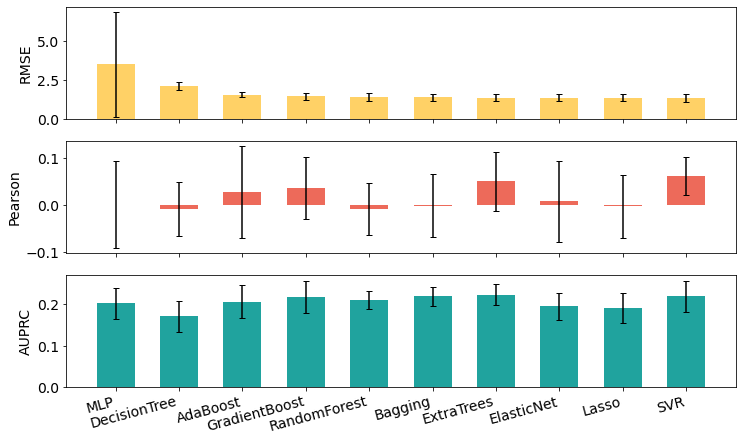

In [28]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.3-single_group5foldcv_uniprot_barplot.pdf"))
plt.show()

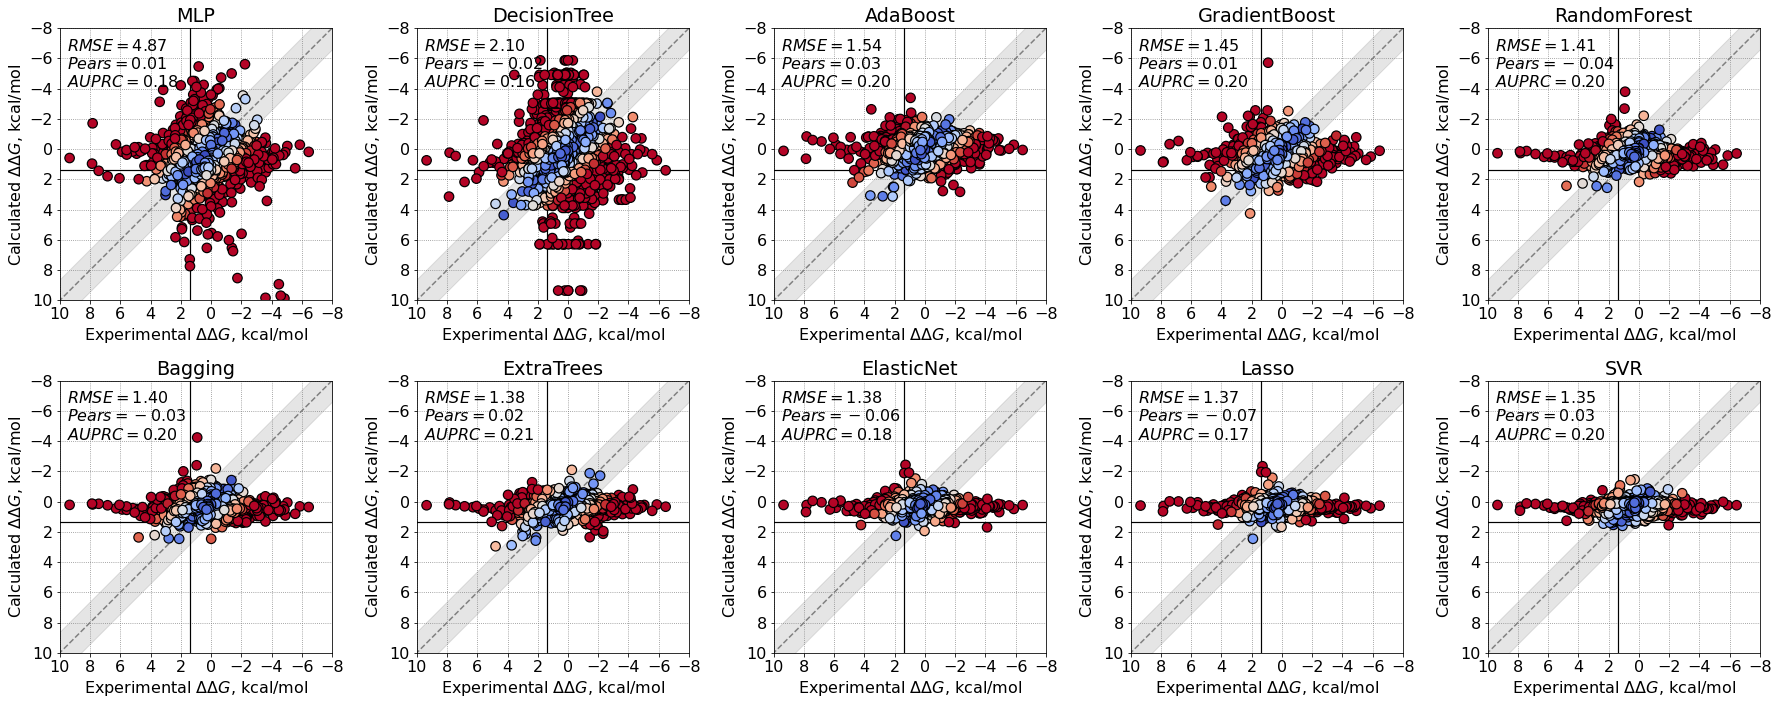

In [29]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.3-single_group5foldcv_uniprot_scatterplot.pdf"))
plt.show()

____
#### Scenario 1.4: 5-fold nested cross-validation (protein sequence). 
Protein sequences are obtained according to Uniprot ID and encoded by the one-hot encoding. Then, the protein sequences were divided into 5 groups by k-nearest neighbors (KNN) clustering. We then use 5-fold nested cross-validation. At each iteration, the machine learning method is trained on the 4 folds with 4 groups, while one fold is left to test the method. This process is repeated 5 times to obtain predictions for all data.
____

In [30]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
mdrdb = mdrdb[mdrdb['UNIPROT_ID'] != 'UNDEFINED'].reset_index(drop=True)
print(f"Number of samples: {mdrdb.shape[0]}")

Number of samples: 3682


In [31]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/tmp"
file_name = "MdrDBCoreset_single_uniq_seq.fasta"

# set a dict recored the uniprot id
uniprot_change_dict = {"A5F1K1": "Q9KNC3", "P03176": "P0DTH5", "P46084": "P0DPR0"}

if os.path.exists(os.path.join(save_path, file_name)):
    with open(os.path.join(save_path, file_name), 'rb') as f:
        lines = []
        for line in f:
            line = line.decode('utf-8')
            line = line.replace('\n', '')
            
            if line.startswith(">"):
                lines.append(line)
            else:
                lines[-1] += "+" + line
    
else:
    # obtain the uniprot id
    uniprot_ids = list(mdrdb["UNIPROT_ID"].unique())
    # change the old version uniprot id to the new uniprot id
    uniprot_ids = [uniprot_change_dict[id] if id in uniprot_change_dict.keys() else id for id in uniprot_ids]
    print(f"Number of uniprot id: {len(uniprot_ids)}")
    
    uniprot_seq_dict = {}
    for uniprot_id in tqdm(uniprot_ids):
        sequence = get_protein_sequence(uniprot_id)
        uniprot_seq_dict[uniprot_id] = sequence
    
    with open(os.path.join(save_path, save_file), 'wb') as f:
        for key in uniprot_seq_dict.keys():
            data = f">{key}\n{uniprot_seq_dict[key]}\n"
            f.write(data.encode())
    f.close()    

In [32]:
# encoding the protein FASTA sequence.
# Amini acid list, and '-'
amino_acids = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 
               'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', '-']

# Constract one hot encoding map
aa_dict = {x: i for i, x in enumerate(amino_acids)}
            
# Construct a dict (key: Uniprot id; value: Sequence)
sequences_dict = {}
sequences = []
for line in lines:
    uniprot_id = line.split('+')[0].split('>')[1]
    sequence = line.split('+')[1]
    sequences_dict[uniprot_id] = sequence
    sequences.append(sequence)

# Find the max length of the sequences
max_len = max(len(seq) for seq in sequences)
print(f"The max length of the protein sequences is: {max_len}")

# initialize the encoded
onehot_encoded = np.zeros((len(sequences), max_len, 21))

# One hot encode each sequence
i = 0
for uniid, seq in sequences_dict.items():
    # sequence alignments
    seq += '-' * (max_len - len(seq))
    
    for j, aa in enumerate(seq):
        index = aa_dict.get(aa, 0)
        onehot_encoded[i, j, index] = 1
    i += 1
print(onehot_encoded.shape) # (n_sequences, max_len, 21)

# Translate into 2d-array
onehot_encoded_2d = np.reshape(onehot_encoded, (onehot_encoded.shape[0], -1))
print(onehot_encoded_2d.shape)

The max length of the protein sequences is: 4558
(231, 4558, 21)
(231, 95718)


In [33]:
# KNN clustering
kmeans = KMeans(n_clusters=n_fold, random_state=0)  
kmeans.fit(onehot_encoded_2d)

# record the labels of KNN
labels = kmeans.labels_   # 聚类标签

# Add the KNN labels to the MdrDBCoreset
uniprot_knn_dict = {}
i = 0
for key in sequences_dict.keys():
    uniprot_knn_dict[key] = str(labels[i])
    i += 1

In [34]:
for i in tqdm(range(mdrdb.shape[0])):
    uniprot_id = mdrdb.loc[i, "UNIPROT_ID"]
    if uniprot_id in uniprot_change_dict.keys():
        mdrdb.loc[i, 'KNN_cluster'] = uniprot_knn_dict[uniprot_change_dict[uniprot_id]]
    else:
        mdrdb.loc[i, 'KNN_cluster'] = uniprot_knn_dict[uniprot_id]

100%|██████████| 3682/3682 [00:01<00:00, 2907.32it/s]


In [35]:
y = mdrdb["DDG.EXP"]
groups = mdrdb['KNN_cluster']
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET', 'KNN_cluster']
X = mdrdb.drop(todrop, axis=1)
X = X.astype(float)

result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    for train_idx, test_idx in LeaveOneGroupOut().split(X=X, groups=groups):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
    
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 17:46:49] ---current model is: DecisionTree---
[2023-04-21 17:46:51] Mean RMSE score: 2.00
[2023-04-21 17:46:51] RMSE standard deviation: 0.26
[2023-04-21 17:46:51] ---current model is: RandomForest---
[2023-04-21 17:48:20] Mean RMSE score: 1.44
[2023-04-21 17:48:20] RMSE standard deviation: 0.29
[2023-04-21 17:48:20] ---current model is: ExtraTrees---
[2023-04-21 17:48:50] Mean RMSE score: 1.44
[2023-04-21 17:48:50] RMSE standard deviation: 0.28
[2023-04-21 17:48:50] ---current model is: Bagging---
[2023-04-21 17:50:19] Mean RMSE score: 1.44
[2023-04-21 17:50:19] RMSE standard deviation: 0.29
[2023-04-21 17:50:19] ---current model is: AdaBoost---
[2023-04-21 17:51:20] Mean RMSE score: 1.60
[2023-04-21 17:51:20] RMSE standard deviation: 0.27
[2023-04-21 17:51:20] ---current model is: GradientBoost---
[2023-04-21 17:54:09] Mean RMSE score: 1.52
[2023-04-21 17:54:09] RMSE standard deviation: 0.30
[2023-04-21 17:54:09] ---current model is: SVR---
[2023-04-21 17:54:14] Mean RMS

In [36]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False).reset_index(drop=True)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
0            MLP     2.948     0.813       -0.016        0.036      0.202   
1   DecisionTree     1.998     0.260       -0.031        0.085      0.188   
2       AdaBoost     1.601     0.270        0.072        0.068      0.227   
3  GradientBoost     1.523     0.300       -0.013        0.075      0.198   
4     ElasticNet     1.453     0.278       -0.075        0.098      0.196   
5          Lasso     1.440     0.280       -0.052        0.097      0.195   
6     ExtraTrees     1.437     0.283        0.003        0.063      0.199   
7        Bagging     1.437     0.290        0.002        0.106      0.211   
8   RandomForest     1.436     0.288        0.002        0.096      0.207   
9            SVR     1.408     0.291        0.072        0.034      0.240   

   AUPRC_std  
0      0.067  
1      0.053  
2      0.075  
3      0.070  
4      0.077  
5      0.078  
6      0.063  
7      0.085  
8      0.086  
9      0.050

In [37]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.4-single_5foldnestedcv_sequence_ddG.pkl"
save_perf = "S1.4-single_5foldnestedcv_sequence_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

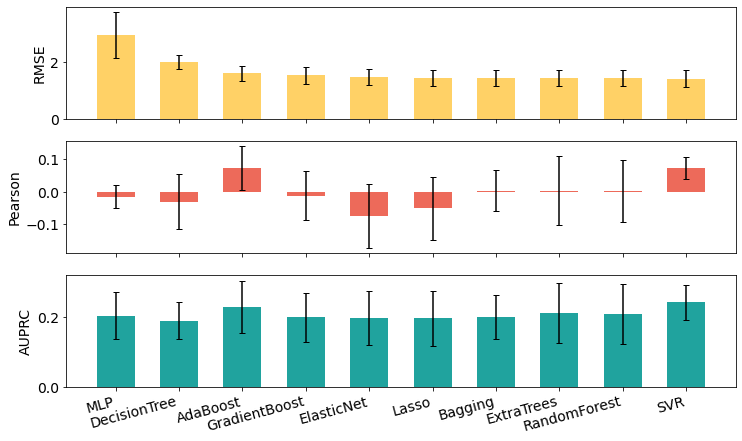

In [38]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.4-single_5foldnestedcv_sequence_barplot.pdf"))
plt.show()

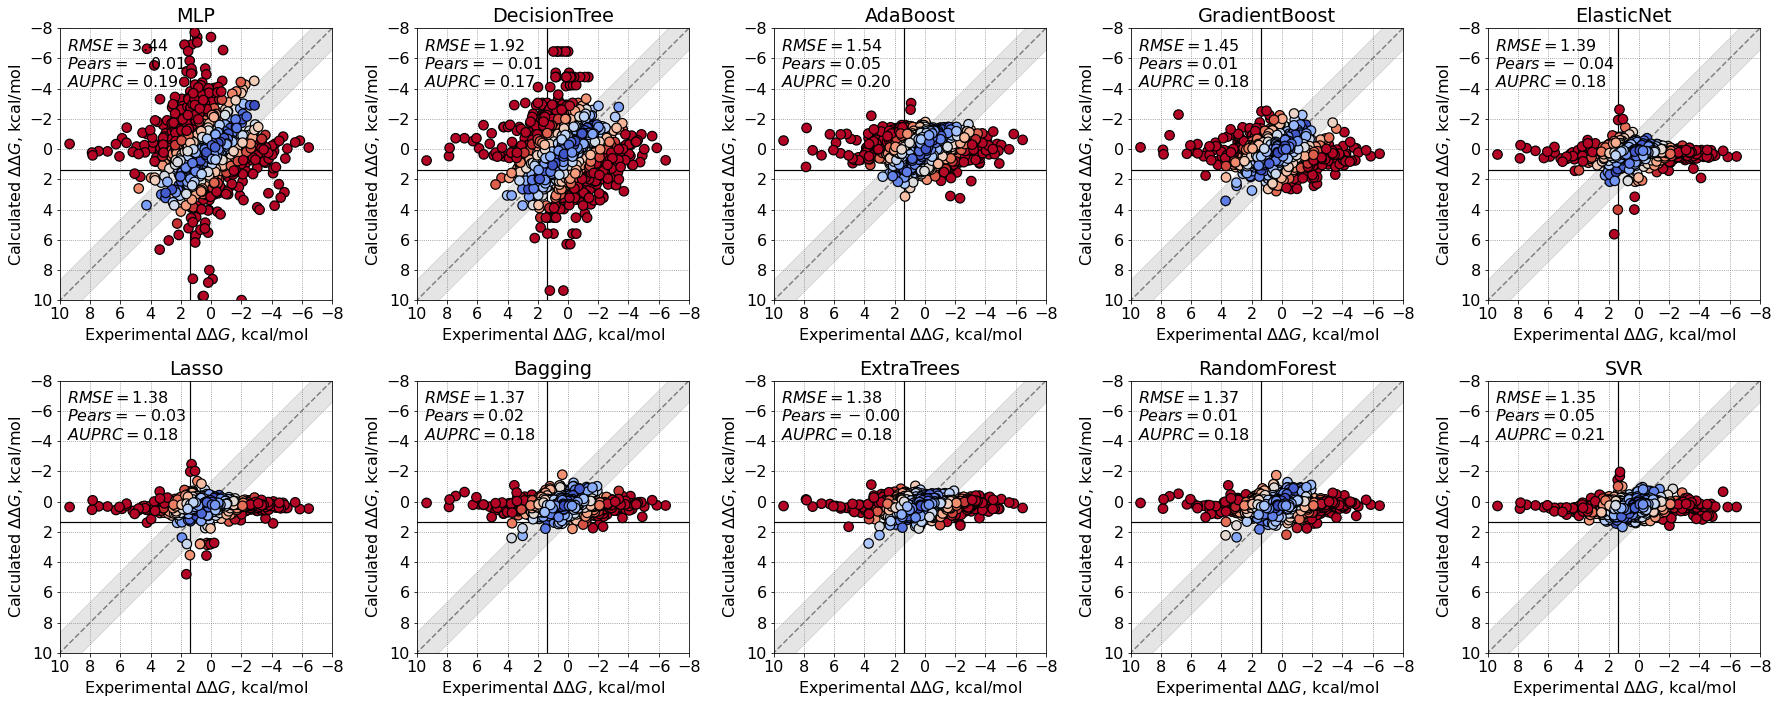

In [39]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.4-single_5foldnestedcv_sequence_scatterplot.pdf"))
plt.show()

____
#### Scenario 1.5: Group 5-fold corss-validation (drug name). 
Grouping samples according to the drug name, and all data is randomly divided into 5 folds, where the same group does not appear in two different folds. The machine learning method is trained on the 4 folds, while one fold is left to test the method. This process is repeated 5 times to obtain predictions for all data.
____

In [40]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)

y = mdrdb_single["DDG.EXP"]
groups = mdrdb_single["DRUG"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_single.drop(todrop, axis=1)
X = X.astype(float)

print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_single.shape[0]}")
print(f"Number of groups: {len(groups.unique())}")

Number of samples in Single Substitution of MdrDBCoreset: 3697
Number of groups: 392


In [41]:
result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    # Define the cross-validation method
    cv = GroupKFold(n_splits=n_fold)
    
    # Perform cross-validation
    rmse_scores = []
    for train_index, test_index in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
        
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 17:54:45] ---current model is: DecisionTree---
[2023-04-21 17:54:47] Mean RMSE score: 1.86
[2023-04-21 17:54:47] RMSE standard deviation: 0.21
[2023-04-21 17:54:47] ---current model is: RandomForest---
[2023-04-21 17:56:16] Mean RMSE score: 1.33
[2023-04-21 17:56:16] RMSE standard deviation: 0.21
[2023-04-21 17:56:16] ---current model is: ExtraTrees---
[2023-04-21 17:56:47] Mean RMSE score: 1.33
[2023-04-21 17:56:47] RMSE standard deviation: 0.21
[2023-04-21 17:56:47] ---current model is: Bagging---
[2023-04-21 17:58:17] Mean RMSE score: 1.33
[2023-04-21 17:58:17] RMSE standard deviation: 0.21
[2023-04-21 17:58:17] ---current model is: AdaBoost---
[2023-04-21 17:59:18] Mean RMSE score: 1.56
[2023-04-21 17:59:18] RMSE standard deviation: 0.14
[2023-04-21 17:59:18] ---current model is: GradientBoost---
[2023-04-21 18:02:08] Mean RMSE score: 1.42
[2023-04-21 18:02:08] RMSE standard deviation: 0.21
[2023-04-21 18:02:08] ---current model is: SVR---
[2023-04-21 18:02:14] Mean RMS

In [42]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by='RMSE_avg', ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
9            MLP     4.684     4.267        0.036        0.093      0.232   
0   DecisionTree     1.859     0.207        0.039        0.056      0.188   
4       AdaBoost     1.562     0.145        0.024        0.044      0.213   
5  GradientBoost     1.419     0.213        0.075        0.040      0.235   
7     ElasticNet     1.358     0.214       -0.018        0.020      0.188   
8          Lasso     1.351     0.213       -0.022        0.021      0.188   
3        Bagging     1.334     0.212        0.115        0.048      0.274   
6            SVR     1.331     0.215        0.076        0.039      0.217   
1   RandomForest     1.328     0.210        0.125        0.045      0.278   
2     ExtraTrees     1.327     0.205        0.161        0.075      0.300   

   AUPRC_std  
9      0.052  
0      0.052  
4      0.045  
5      0.035  
7      0.035  
8      0.034  
3      0.052  
6      0.048  
1      0.057  
2      0.060

In [43]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.5-single_group5foldcv_drug_ddG.pkl"
save_perf = "S1.5-single_group5foldcv_drug_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

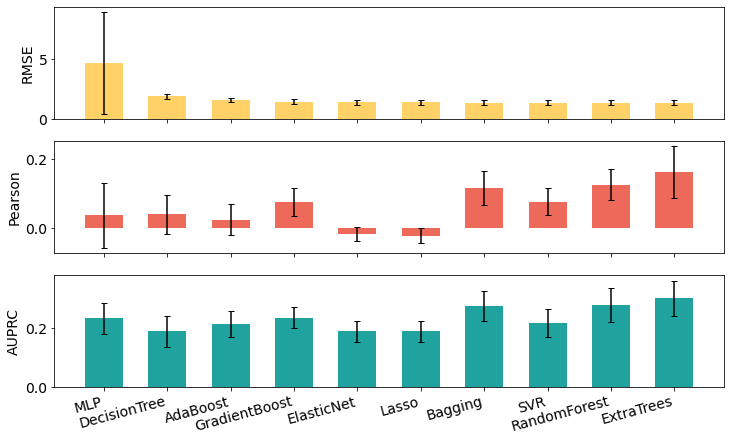

In [44]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.5-single_group5foldcv_drug_barplot.pdf"))
plt.show()

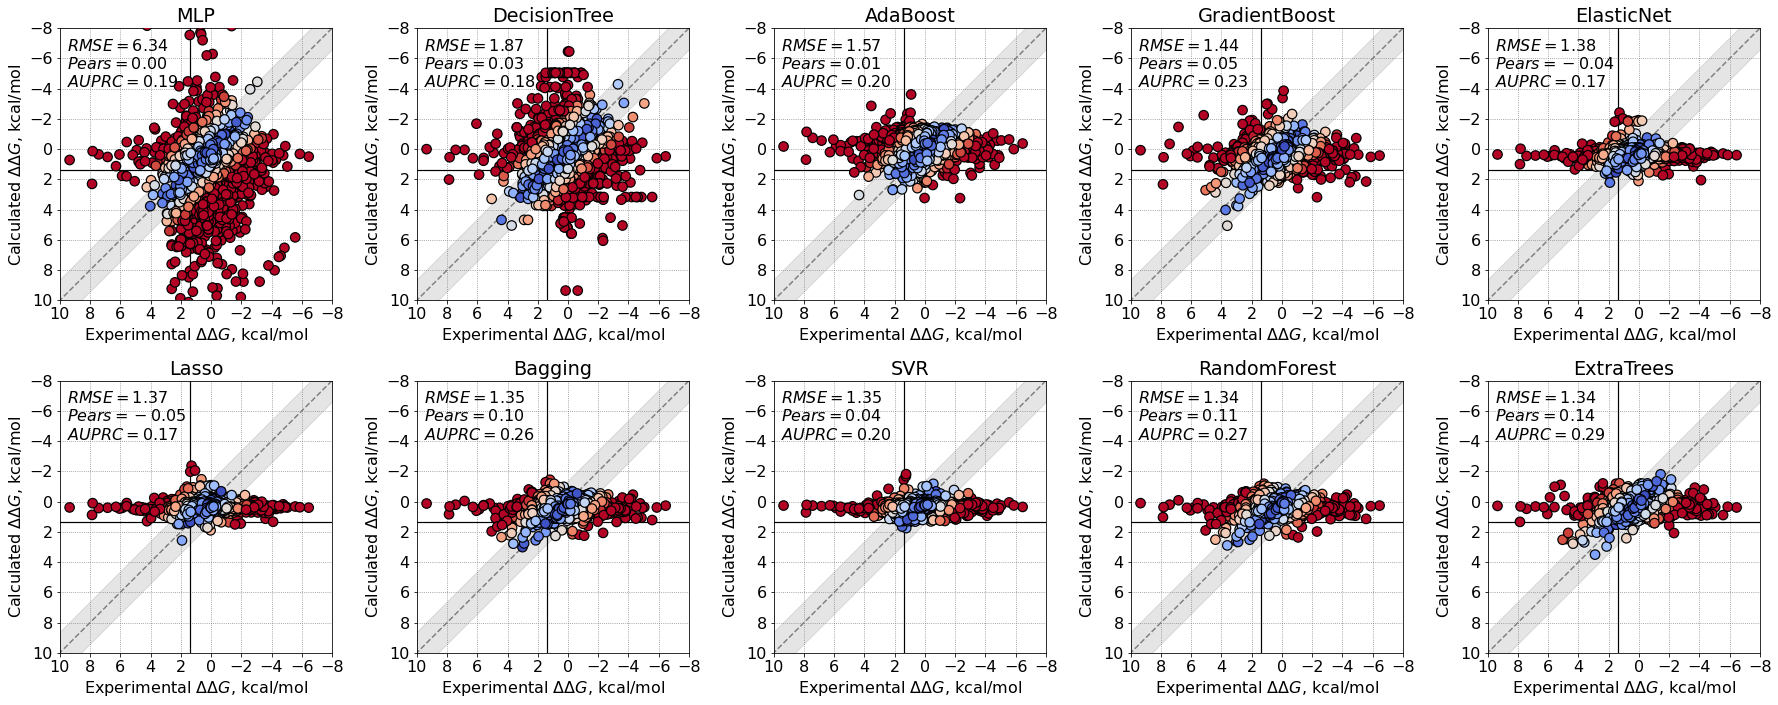

In [45]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.5-single_group5foldcv_drug_scatterplot.pdf"))
plt.show()

____
#### Scenario 1.6: 5-fold nested cross-validation (SMILES). 
SMILES strings are first converted into molecular fingerprints, which are binary vectors that encode the presence or absence of certain substructures in the molecule. Pairwise Tanimoto similarity between fingerprints is then calculated as a measure of similarity between molecules. Finally, KNN clustering algorithm is used to group similar molecules into 5 clusters based on their pairwise similarities. We then use 5-fold nested cross-validation. At each iteration, the machine learning method is trained on the 4 folds with 4 groups, while one fold is left to test the method. This process is repeated 5 times to obtain predictions for all data.

____

In [46]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
mdrdb.head()

SAMPLE_ID    VERSION DATASET                 TYPE UNIPROT_ID MUTATION  \
0  MdrDBcore00052  V1.0.2022   AIMMS  Single Substitution     A7UD81     A16C   
1  MdrDBcore00053  V1.0.2022   AIMMS  Single Substitution     A7UD81     A16C   
2  MdrDBcore00054  V1.0.2022   AIMMS  Single Substitution     A7UD81     A16G   
3  MdrDBcore00055  V1.0.2022   AIMMS  Single Substitution     A7UD81     A16G   
4  MdrDBcore00056  V1.0.2022   AIMMS  Single Substitution     A7UD81     A16S   

            DRUG                                SMILES SAMPLE_PDB_ID  DDG.EXP  \
0    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C          3UM8     0.07   
1  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl          3QGT     0.17   
2    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C          3UM8     0.74   
3  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl          3QGT     0.50   
4    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C          3UM8     2.63   

   ... P2dp.P P2dp.N P2dp.DA P2dp.D P2dp.A P2dp.AR P2dp.H P2dp.PL P2dp.HA  \
0  ...    0.0    0.0     0.0    0.0   6.76   -1.76 -11.03   -2.37     0.0   
1  ...    0.0    0.0     0.0    0.0   7.93   -1.65  -8.81   -2.38     0.0   
2  ...    0.0    0.0     0.0    0.0   0.67    1.54  -6.07    4.33     0.0   
3  ...    0.0    0.0     0.0    0.0   0.40    1.14  -4.57    3.41     0.0   
4  ...    0.0    0.0     0.0    0.0   7.85   -1.45  -8.63   -1.14     0.0   

  P2dp.SA  
0   -8.40  
1   -4.90  
2    0.47  
3    0.38  
4   -3.36  

[5 rows x 167 columns]

In [47]:
# Define a function that converts SMILES strings to molecular fingerprints
def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    return np.array(fp)

# Define a function that calculates pairwise Tanimoto similarity between fingerprints
def tanimoto_similarity(fp1, fp2):
    return np.sum(np.bitwise_and(fp1, fp2)) / np.sum(np.bitwise_or(fp1, fp2))

# Load SMILES strings into a list
smiles_list = mdrdb["SMILES"].to_list()

# Convert SMILES strings to fingerprints
fingerprints = [smiles_to_fingerprint(smiles) for smiles in smiles_list]

# Calculate pairwise Tanimoto similarity between fingerprints
similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))
for i in range(len(fingerprints)):
    for j in range(i+1, len(fingerprints)):
        similarity_matrix[i,j] = tanimoto_similarity(fingerprints[i], fingerprints[j])
        similarity_matrix[j,i] = similarity_matrix[i,j]

# Perform KNN clustering with 5 clusters
kmeans = KMeans(n_clusters=n_fold).fit(similarity_matrix)

# Print cluster assignments
print(kmeans.labels_)
mdrdb["SMILES_GROUP"] = kmeans.labels_

[1 1 1 ... 2 2 2]


In [48]:
y = mdrdb["DDG.EXP"]
groups = mdrdb['SMILES_GROUP']
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET', 'SMILES_GROUP']
X = mdrdb.drop(todrop, axis=1)
X = X.astype(float)

result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    for train_idx, test_idx in LeaveOneGroupOut().split(X=X, groups=groups):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
    
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 18:04:56] ---current model is: DecisionTree---
[2023-04-21 18:04:57] Mean RMSE score: 1.70
[2023-04-21 18:04:57] RMSE standard deviation: 0.20
[2023-04-21 18:04:57] ---current model is: RandomForest---
[2023-04-21 18:06:26] Mean RMSE score: 1.18
[2023-04-21 18:06:26] RMSE standard deviation: 0.24
[2023-04-21 18:06:26] ---current model is: ExtraTrees---
[2023-04-21 18:06:56] Mean RMSE score: 1.19
[2023-04-21 18:06:56] RMSE standard deviation: 0.24
[2023-04-21 18:06:56] ---current model is: Bagging---
[2023-04-21 18:08:25] Mean RMSE score: 1.19
[2023-04-21 18:08:25] RMSE standard deviation: 0.23
[2023-04-21 18:08:25] ---current model is: AdaBoost---
[2023-04-21 18:09:27] Mean RMSE score: 1.40
[2023-04-21 18:09:27] RMSE standard deviation: 0.25
[2023-04-21 18:09:27] ---current model is: GradientBoost---
[2023-04-21 18:12:16] Mean RMSE score: 1.23
[2023-04-21 18:12:16] RMSE standard deviation: 0.28
[2023-04-21 18:12:16] ---current model is: SVR---
[2023-04-21 18:12:22] Mean RMS

In [49]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sotrted = results.sort_values(by='RMSE_avg', ascending=False)
results_sotrted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
9            MLP     2.615     1.852        0.039        0.044      0.183   
0   DecisionTree     1.703     0.203        0.022        0.031      0.234   
4       AdaBoost     1.395     0.252       -0.070        0.043      0.194   
5  GradientBoost     1.233     0.278        0.070        0.109      0.191   
3        Bagging     1.192     0.230        0.018        0.054      0.186   
7     ElasticNet     1.190     0.254       -0.019        0.046      0.173   
8          Lasso     1.189     0.249       -0.034        0.039      0.177   
2     ExtraTrees     1.186     0.244        0.042        0.121      0.216   
6            SVR     1.184     0.232        0.047        0.058      0.181   
1   RandomForest     1.181     0.244        0.016        0.056      0.191   

   AUPRC_std  
9      0.089  
0      0.089  
4      0.130  
5      0.123  
3      0.123  
7      0.099  
8      0.097  
2      0.151  
6      0.123  
1      0.133

In [50]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.6-single_5foldnestedcv_smiles_ddG.pkl"
save_perf = "S1.6-single_5foldnestedcv_smiles_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sotrted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sotrted

result_ddg = pd.DataFrame(result_ddg)

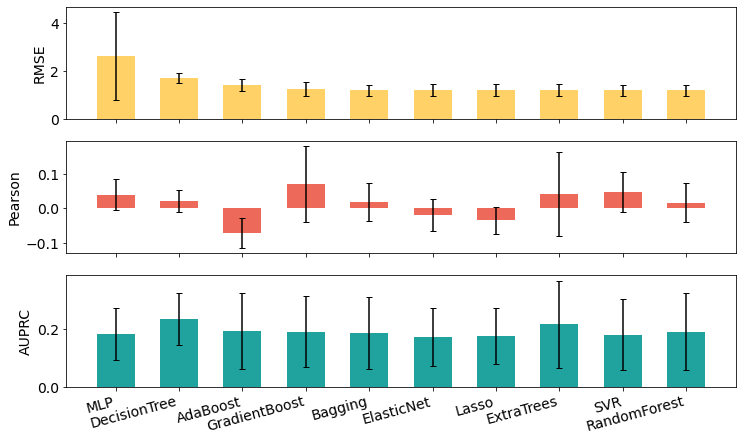

In [51]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.6-single_5foldnestedcv_smiles_barplot.pdf"))
plt.show()

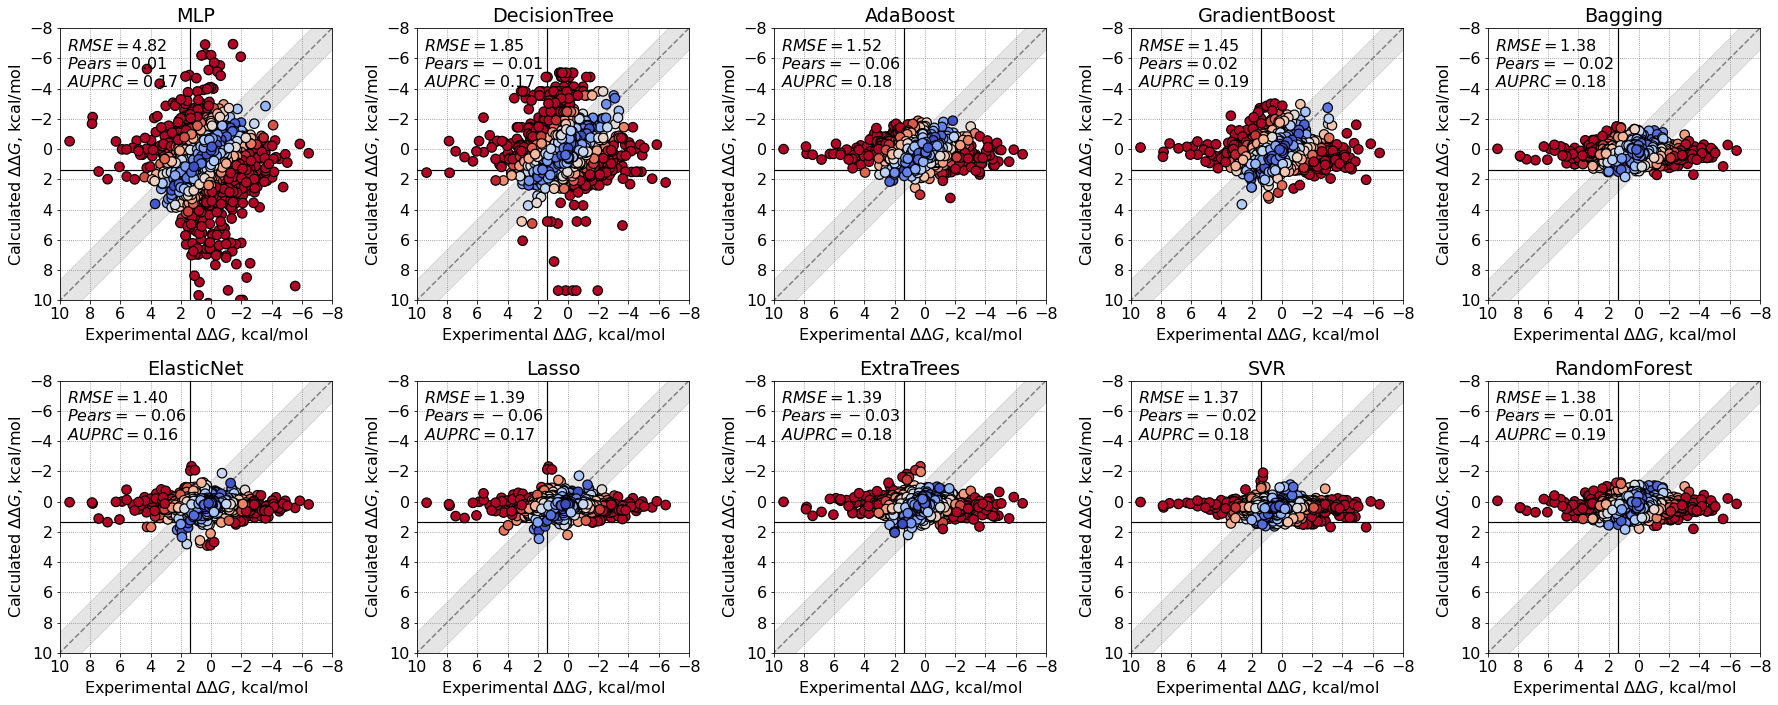

In [52]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.6-single_5foldnestedcv_smiles_scatterplot.pdf"))
plt.show()

____
#### Scenario 1.7: 25-fold nested cross-validation (amino acid type).
Amino acid type changes (from wild type to mutation) are extracted from mutation information of the dataset. For instance, the mutation information of one data is "A256R", in which amino acid A belongs to the Hydrophobic group and amino acid R belongs to the Positve group. Then, the amino acid type of this data is "Hydrophobic_Positve". In the manuscript, the 20 amino acids are divided into five groups (i.e., positive, negative, polar, special cases, and hydrophbic). Thus, there are a total of 5*5=25 groups of amino acid changes before and after mutation. Grouping samples according to the amino acid type changes. The machine learning method is trained on the 24 folds, while one fold is left to test the method. This process is repeated 25 times to obtain predictions for all data.
____

In [53]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)

# prepare aa_type_dict
aa_type_dict = {'A': "Hydrophobic", 'R': "Positive", 'N': "Polar", 'D': "Negative", 'C': "Special Cases", 
                'Q': "Polar", 'E': "Negative", 'G': "Special Cases", 'H': "Positive", 'I': "Hydrophobic", 
                'L': "Hydrophobic", 'K': "Positive", 'M': "Hydrophobic", 'F': "Hydrophobic", 'P': "Special Cases", 
                'S': "Polar", 'T': "Polar", 'W': "Hydrophobic", 'Y': "Hydrophobic", 'V': "Hydrophobic"}

# generate amini acid type_list(5*5)
type_list = [aa_type_dict[i[0]] + "_" + aa_type_dict[i[-1]] for i in mdrdb["MUTATION"].to_list()]

# check the results
log_message([i for i in mdrdb["MUTATION"].to_list()][:5])
log_message(f"type_list: {type_list[:5]}")

# add aa_type_list to the mdrdb dataframe
mdrdb["AA_TYPE"] = type_list

[2023-04-21 18:12:53] ['A16C', 'A16C', 'A16G', 'A16G', 'A16S']
[2023-04-21 18:12:53] type_list: ['Hydrophobic_Special Cases', 'Hydrophobic_Special Cases', 'Hydrophobic_Special Cases', 'Hydrophobic_Special Cases', 'Hydrophobic_Polar']


In [54]:
y = mdrdb["DDG.EXP"]
groups = mdrdb["AA_TYPE"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET', 'AA_TYPE']
X = mdrdb.drop(todrop, axis=1)
X = X.astype(float)

print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb.shape[0]}")
print(f"Number of groups: {len(groups.unique())}")

Number of samples in Single Substitution of MdrDBCoreset: 3697
Number of groups: 25


In [55]:
result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    for train_idx, test_idx in LeaveOneGroupOut().split(X=X, groups=groups):
        X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
    
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 18:12:53] ---current model is: DecisionTree---
[2023-04-21 18:13:04] Mean RMSE score: 1.70
[2023-04-21 18:13:04] RMSE standard deviation: 0.50
[2023-04-21 18:13:04] ---current model is: RandomForest---
[2023-04-21 18:22:19] Mean RMSE score: 1.15
[2023-04-21 18:22:19] RMSE standard deviation: 0.40
[2023-04-21 18:22:19] ---current model is: ExtraTrees---
[2023-04-21 18:25:17] Mean RMSE score: 1.15
[2023-04-21 18:25:17] RMSE standard deviation: 0.41
[2023-04-21 18:25:17] ---current model is: Bagging---
[2023-04-21 18:34:44] Mean RMSE score: 1.16
[2023-04-21 18:34:44] RMSE standard deviation: 0.39
[2023-04-21 18:34:44] ---current model is: AdaBoost---
[2023-04-21 18:40:38] Mean RMSE score: 1.62
[2023-04-21 18:40:38] RMSE standard deviation: 0.45
[2023-04-21 18:40:38] ---current model is: GradientBoost---
[2023-04-21 18:57:44] Mean RMSE score: 1.20
[2023-04-21 18:57:44] RMSE standard deviation: 0.39
[2023-04-21 18:57:44] ---current model is: SVR---
[2023-04-21 18:58:17] Mean RMS

In [56]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False).reset_index(drop=True)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
0            MLP     1.823     0.599        0.067        0.164      0.230   
1   DecisionTree     1.701     0.497        0.263        0.154      0.293   
2       AdaBoost     1.615     0.454        0.081        0.195      0.241   
3          Lasso     1.364     0.480        0.074        0.169      0.228   
4     ElasticNet     1.359     0.482        0.113        0.146      0.238   
5            SVR     1.344     0.474        0.178        0.130      0.261   
6  GradientBoost     1.204     0.392        0.482        0.168      0.392   
7        Bagging     1.157     0.395        0.541        0.164      0.473   
8   RandomForest     1.154     0.396        0.544        0.167      0.459   
9     ExtraTrees     1.151     0.413        0.542        0.154      0.475   

   AUPRC_std  
0      0.100  
1      0.109  
2      0.100  
3      0.113  
4      0.119  
5      0.126  
6      0.128  
7      0.170  
8      0.165  
9      0.169

In [57]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.7-single_25foldnestedcv_aatype_ddG.pkl"
save_perf = "S1.7-single_25foldnestedcv_aatype_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

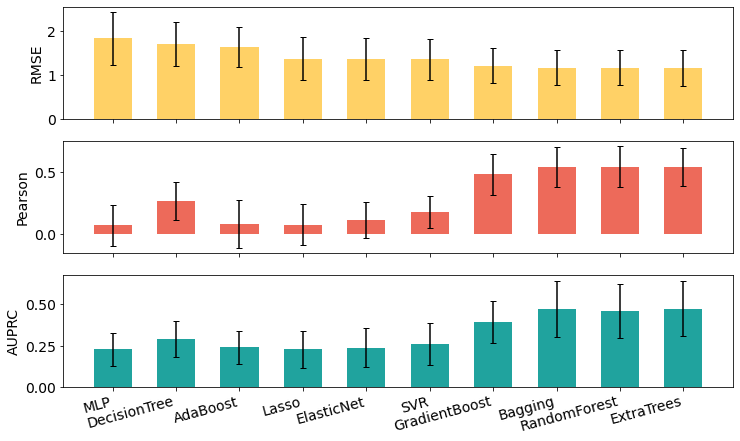

In [58]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.7-single_25foldnestedcv_aatype_barplot.pdf"))
plt.show()

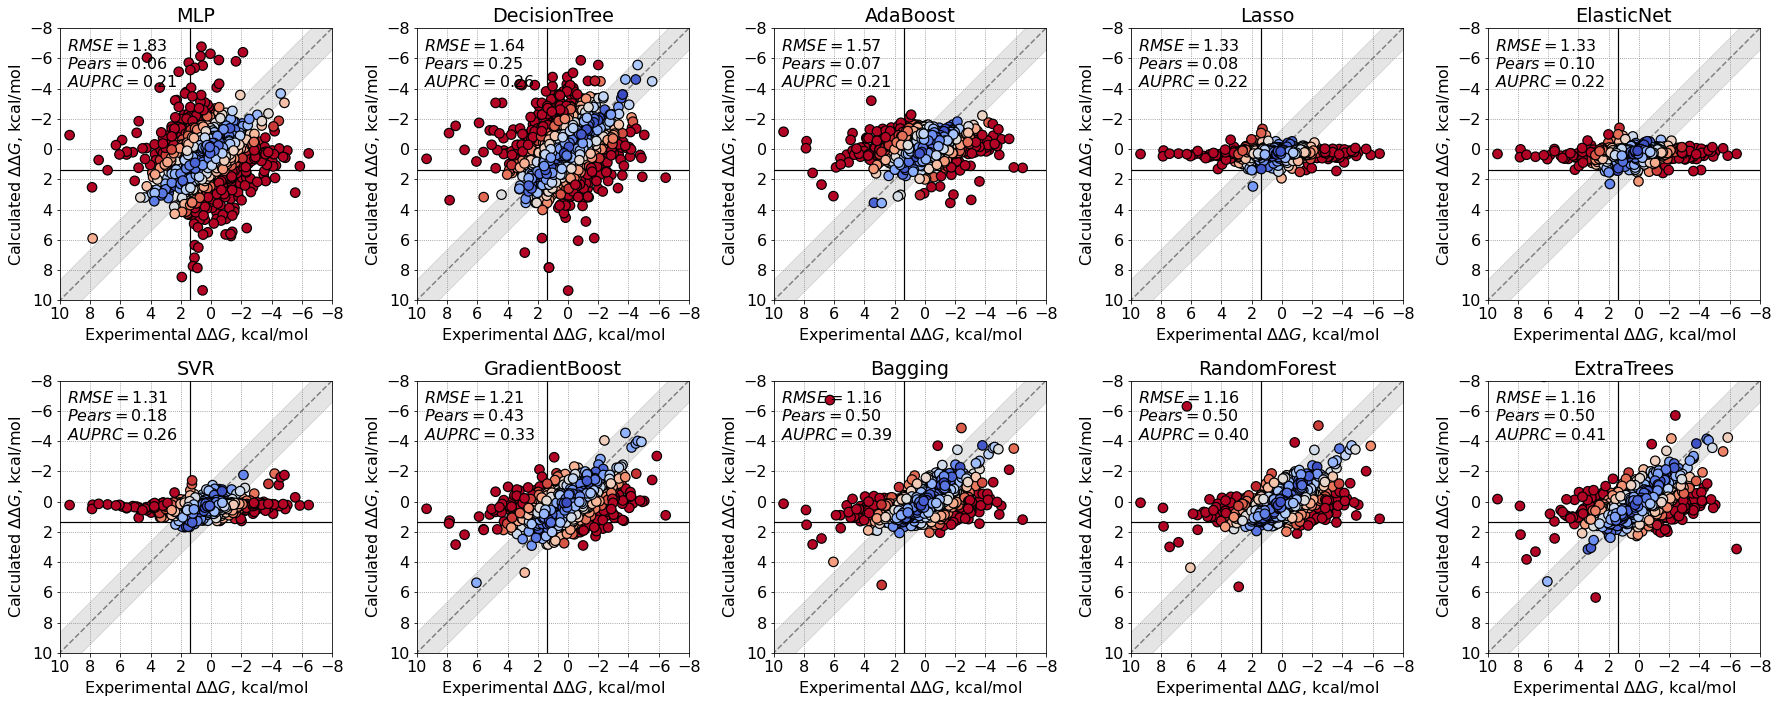

In [59]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.7-single_25foldnestedcv_aatype_scatterplot.pdf"))
plt.show()

____
#### Scenario 1.8: 237-fold nested corss-validation (amino acid). 
Amino acid changes (from wild type to mutation) are extracted from mutation information of the dataset. For instance, the mutation information of one data is "A256R", the amino acid change of this data is "A_R". Grouping samples according to the amino acid changes (237 groups).  The machine learning method is trained on the 236 folds, while one fold is left to test the method. This process is repeated 237 times to obtain predictions for all data.
____

In [60]:
# select single substitution samples
mut_type = "Single Substitution"
mdrdb = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)

# generate type_list(<20*20)
type_list = [i[0] + "_" + i[-1] for i in mdrdb['MUTATION'].to_list()]
print(f"Number of type: {len(set(type_list))}")

# add type_list to the mdrdb dataframe
mdrdb["AA_TYPE"] = type_list

Number of type: 237


In [61]:
y = mdrdb["DDG.EXP"]
groups = mdrdb["AA_TYPE"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET', 'AA_TYPE']
X = mdrdb.drop(todrop, axis=1)
X = X.astype(float)

print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb.shape[0]}")
print(f"Number of groups: {len(groups.unique())}")

Number of samples in Single Substitution of MdrDBCoreset: 3697
Number of groups: 237


In [62]:
result_dict = {}
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = {}
    result_dict[model]["label_true"] = []
    result_dict[model]["label_pred"] = []

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model) 
    
    # Define the cross-validation method
    cv = GroupKFold(n_splits=n_fold)
    
    # Perform cross-validation
    rmse_scores = []
    for train_index, test_index in cv.split(X, y, groups):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Fit the model on the training data
        method.fit(X_train, y_train)
        
        # Make predictions on the test data
        y_pred = method.predict(X_test)
        
        # Calculate the RMSE score
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        pears = get_pearson(y_test, y_pred)
        auprc = get_auc_prc(y_test, y_pred)
        
        rmse_dict[model].append(rmse)
        pears_dict[model].append(pears)
        prc_dict[model].append(auprc)
        
        # Store predicted and exp data
        result_dict[model]['label_true'].extend(y_test)
        result_dict[model]['label_pred'].extend(y_pred)
        
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(np.array(rmse_dict[model]).mean()))
    log_message("RMSE standard deviation: {:.2f}".format(np.array(rmse_dict[model]).std()))

[2023-04-21 18:59:45] ---current model is: DecisionTree---
[2023-04-21 18:59:46] Mean RMSE score: 1.60
[2023-04-21 18:59:46] RMSE standard deviation: 0.04
[2023-04-21 18:59:46] ---current model is: RandomForest---
[2023-04-21 19:01:19] Mean RMSE score: 1.15
[2023-04-21 19:01:19] RMSE standard deviation: 0.07
[2023-04-21 19:01:19] ---current model is: ExtraTrees---
[2023-04-21 19:01:50] Mean RMSE score: 1.14
[2023-04-21 19:01:50] RMSE standard deviation: 0.05
[2023-04-21 19:01:50] ---current model is: Bagging---
[2023-04-21 19:03:23] Mean RMSE score: 1.15
[2023-04-21 19:03:23] RMSE standard deviation: 0.06
[2023-04-21 19:03:23] ---current model is: AdaBoost---
[2023-04-21 19:04:24] Mean RMSE score: 1.54
[2023-04-21 19:04:24] RMSE standard deviation: 0.09
[2023-04-21 19:04:24] ---current model is: GradientBoost---
[2023-04-21 19:07:13] Mean RMSE score: 1.19
[2023-04-21 19:07:13] RMSE standard deviation: 0.06
[2023-04-21 19:07:13] ---current model is: SVR---
[2023-04-21 19:07:19] Mean RMS

In [63]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False).reset_index(drop=True)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
0            MLP     6.535     6.663        0.066        0.038      0.222   
1   DecisionTree     1.603     0.040        0.261        0.112      0.271   
2       AdaBoost     1.543     0.092        0.141        0.106      0.235   
3          Lasso     1.325     0.109        0.110        0.016      0.235   
4     ElasticNet     1.323     0.108        0.128        0.024      0.243   
5            SVR     1.305     0.108        0.199        0.032      0.267   
6  GradientBoost     1.187     0.057        0.461        0.051      0.351   
7        Bagging     1.153     0.065        0.509        0.065      0.423   
8   RandomForest     1.150     0.065        0.513        0.063      0.424   
9     ExtraTrees     1.142     0.053        0.518        0.061      0.449   

   AUPRC_std  
0      0.019  
1      0.058  
2      0.043  
3      0.023  
4      0.025  
5      0.032  
6      0.067  
7      0.070  
8      0.073  
9      0.071

In [64]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S1.8-single_237foldnestedcv_aa_ddG.pkl"
save_perf = "S1.8-single_237foldnestedcv_aa_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

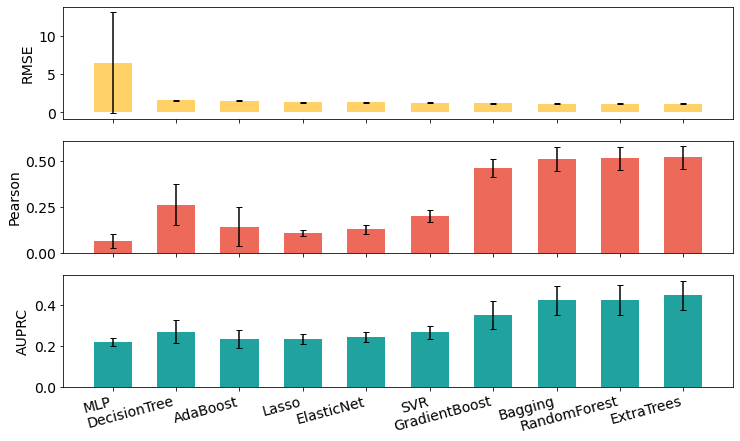

In [65]:
# plot1: bar plot
import matplotlib.pyplot as plt
import matplotlib as mpl

# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.8-single_237foldnestedcv_aa_barplot.pdf"))
plt.show()

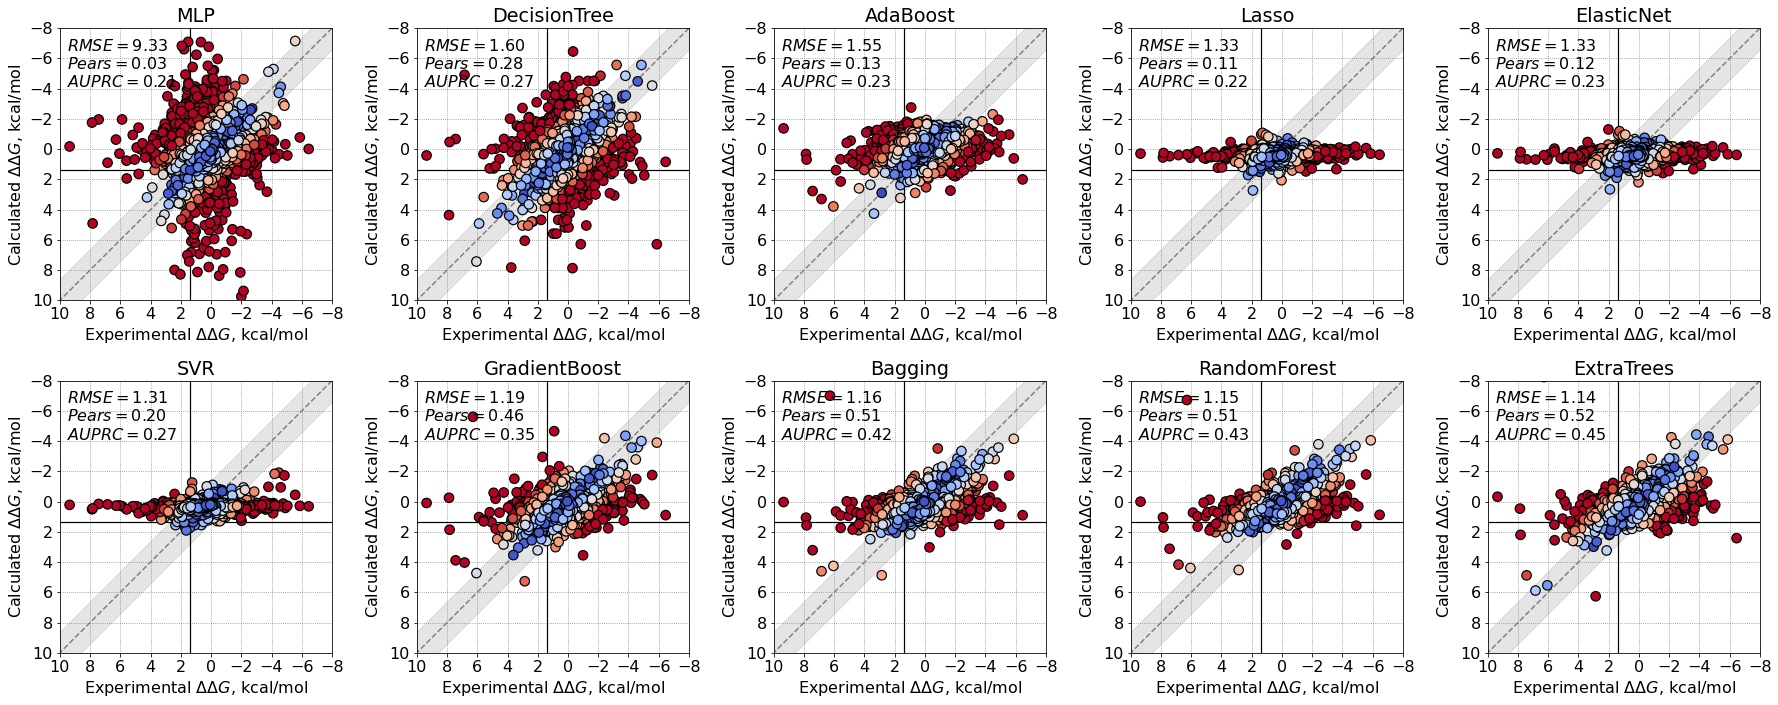

In [66]:
# plot 2. Scatter plot
# reindex the dataframe with the new oder of columns
result_ddg = result_ddg.reindex(columns=x_sorted)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = np.array(result_ddg.iloc[0, i])
    ddg_cal = np.array(result_ddg.iloc[1, i])
    
    xlim = [-8, 10]
    ylim = [-8, 10]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg.columns[i], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 9.5
    anny = -6.5
    asep = -1.2
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    ax.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8, 10])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S1.8-single_237foldnestedcv_aa_scatterplot.pdf"))
plt.show()

____
### Scenario 2: Evaluate the prediction performance of the machine learning methods on the MdrDB_Coreset, which samples belonging to multiple substitution.
___
#### Scenario 2.1: Randomly split the samples (multiple substitution). 
Approximately 80% of the data became training samples, and the remaining 20% were test samples.
___


In [11]:
# import dataset

# according to your path to change the coreset_path
coreset_path = "/data1/Project/Resistance_Database/Coscmd/MdrDB_CoreSet_release_v1.0.2022.tsv"

# import MdrDB_Coreset
mdrdb_coreset = pd.read_csv(coreset_path, sep = "\t")

print(f"Number of samples in MdrDBCoreset: {mdrdb_coreset.shape[0]}")
mdrdb_coreset.head()

Number of samples in MdrDBCoreset: 4292


SAMPLE_ID    VERSION DATASET                   TYPE UNIPROT_ID  \
0  MdrDBcore00000  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
1  MdrDBcore00001  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
2  MdrDBcore00002  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
3  MdrDBcore00003  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   
4  MdrDBcore00004  V1.0.2022   AIMMS  Multiple Substitution     A7UD81   

     MUTATION           DRUG                                SMILES  \
0  A16C+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   
1  A16C+S108T  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl   
2  A16G+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   
3  A16G+S108T  Pyrimethamine  CCC1=C(C(=NC(=N1)N)N)C2=CC=C(C=C2)Cl   
4  A16S+S108T    Cycloguanil   CC1(N=C(N=C(N1C2=CC=C(C=C2)Cl)N)N)C   

  SAMPLE_PDB_ID  DDG.EXP  ... P2dp.P P2dp.N P2dp.DA P2dp.D P2dp.A P2dp.AR  \
0          6A2K     2.42  ...    0.0 -0.640     0.0    0.0  5.425  -0.785   
1          3UM8    -0.41  ...    0.0  1.528     0.0    0.0 -6.215  -0.562   
2          6A2K     2.64  ...    0.0  3.596     0.0    0.0  1.706  -3.122   
3          6A2K     0.31  ...    0.0  1.588     0.0    0.0  1.820  -3.930   
4          6A2K     3.65  ...    0.0 -0.500     0.0    0.0  6.204  -3.214   

  P2dp.H P2dp.PL P2dp.HA P2dp.SA  
0  1.728  -3.165     0.0   2.558  
1  4.638   4.448     0.0   3.835  
2  2.176   4.510     0.0   8.858  
3 -3.077   9.027     0.0   5.428  
4  1.724   1.322     0.0   5.536  

[5 rows x 167 columns]

In [12]:
# Select single substitution samples
mut_type = "Multiple Substitution"
mdrdb_multiple = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_multiple.shape[0]}")

y = mdrdb_multiple["DDG.EXP"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_multiple.drop(todrop, axis=1)
X = X.astype(float)

Number of samples in Multiple Substitution of MdrDBCoreset: 539


In [13]:
# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    mae_dict[model] = []
    r2_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    
for iteration in range(iterations):
    # Randomly split the dataset into 80% training data and 20% test data
    seed = random.randint(0, 100)
    np.random.seed(seed)
    log_message(f"random sampling samples with seed {seed}...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    
    # Training the model
    for model in models_list:
        log_message(f"---current model is: {model}---")
        method = InstantiationModel(model)
        method.fit(X_train, y_train)
        y_pred = method.predict(X_test)

        # record the predicted results
        col_name = f'{model}_iter_{iteration}'
        result_dict[f"label_iter_{iteration}"] = np.array(y_test.to_list())
        result_dict[col_name] = y_pred
        
        # performance
        RMSE = get_rmse(y_test, y_pred)
        MAE = get_mae(y_test, y_pred)
        R2 = get_R2(y_test, y_pred)
        Pears = get_pearson(y_test, y_pred)
        PRC = get_auc_prc(y_test, y_pred)
               
        log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
               
        rmse_dict[model].append(RMSE)
        mae_dict[model].append(MAE)
        r2_dict[model].append(R2)
        pears_dict[model].append(Pears)
        prc_dict[model].append(PRC)

    log_message(f"Finish the {iteration}-th iteration!")

[2023-04-23 17:02:31] random sampling samples with seed 7...
[2023-04-23 17:02:31] ---current model is: DecisionTree---
[2023-04-23 17:02:31] RMSE: 1.8113; MAE: 1.2044; R2: -0.6512; Pears: 0.216; PRC: 0.1864
[2023-04-23 17:02:31] ---current model is: RandomForest---
[2023-04-23 17:02:33] RMSE: 1.31; MAE: 0.8749; R2: 0.1363; Pears: 0.4139; PRC: 0.4067
[2023-04-23 17:02:33] ---current model is: ExtraTrees---
[2023-04-23 17:02:35] RMSE: 1.307; MAE: 0.8447; R2: 0.1402; Pears: 0.4274; PRC: 0.4079
[2023-04-23 17:02:35] ---current model is: Bagging---
[2023-04-23 17:02:38] RMSE: 1.3299; MAE: 0.8935; R2: 0.1099; Pears: 0.3807; PRC: 0.4037
[2023-04-23 17:02:38] ---current model is: AdaBoost---
[2023-04-23 17:02:41] RMSE: 1.3147; MAE: 0.9539; R2: 0.1301; Pears: 0.4175; PRC: 0.4335
[2023-04-23 17:02:41] ---current model is: GradientBoost---
[2023-04-23 17:02:45] RMSE: 1.3285; MAE: 0.9242; R2: 0.1117; Pears: 0.4036; PRC: 0.3899
[2023-04-23 17:02:45] ---current model is: SVR---
[2023-04-23 17:02:45

In [14]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(mae_dict[model]), np.std(mae_dict[model]), 
                            np.mean(r2_dict[model]), np.std(r2_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by='RMSE_avg', ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std  R2_avg  R2_std  \
9            MLP     2.427     0.384    1.689    0.222  -2.408   0.706   
0   DecisionTree     1.537     0.231    1.055    0.165  -0.394   0.391   
7     ElasticNet     1.347     0.093    0.972    0.079  -0.053   0.075   
8          Lasso     1.339     0.092    0.963    0.072  -0.039   0.067   
6            SVR     1.298     0.090    0.910    0.076   0.025   0.031   
4       AdaBoost     1.206     0.066    0.889    0.046   0.156   0.041   
5  GradientBoost     1.162     0.119    0.828    0.067   0.219   0.084   
3        Bagging     1.136     0.118    0.795    0.070   0.253   0.092   
1   RandomForest     1.134     0.111    0.791    0.066   0.255   0.088   
2     ExtraTrees     1.110     0.129    0.747    0.072   0.287   0.092   

   Pearson_avg  Pearson_std  AUPRC_avg  AUPRC_std  
9        0.121        0.070      0.188      0.053  
0        0.319        0.189      0.386      0.215  
7        0.205        0.059      0.315      0.066  
8        0.183        0.060      0.322      0.074  
6        0.179        0.089      0.359      0.045  
4        0.413        0.046      0.514      0.075  
5        0.488        0.075      0.516      0.109  
3        0.513        0.083      0.593      0.140  
1        0.513        0.080      0.583      0.150  
2        0.547        0.077      0.625      0.151

In [34]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S2.1-multiple_randomsplit_ddG.pkl"
save_perf = "S2.1-multiple_randomsplit_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg_one = {}
result_index = "3"
for method in result_ddg.keys():
    if result_index in method:
        result_ddg_one[method] = result_ddg[method]
result_ddg_one = pd.DataFrame(result_ddg_one)

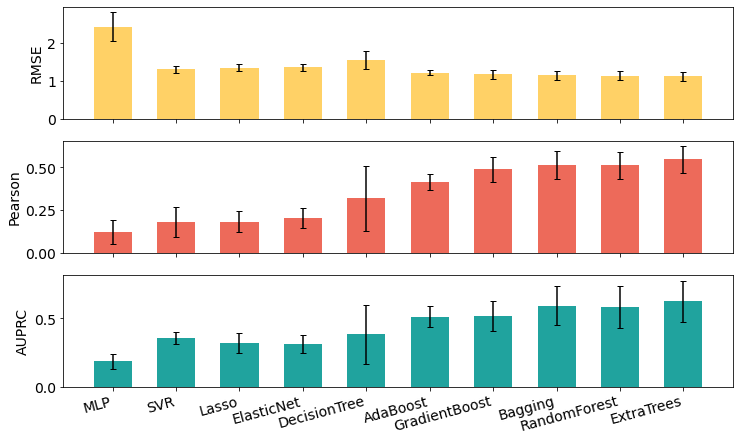

In [35]:
# plot1: bar plot

# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()
auprc = result_perf["AUPRC_avg"].to_list()
auprc_err = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])
auprc_sorted = np.array([auprc[i] for i in sorted_indices])
auprc_err_sorted = np.array([auprc_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S2.1-multiple_randomsplit_barplot.pdf"))
plt.show()

In [36]:
# Rename the columns
result_ddg_one.columns = [i.split("_")[0] for i in result_ddg_one.columns]
columns_name = np.insert(x_sorted, 0, "label")

# Reorder the columns
result_ddg_new = result_ddg_one.reindex(columns=columns_name)

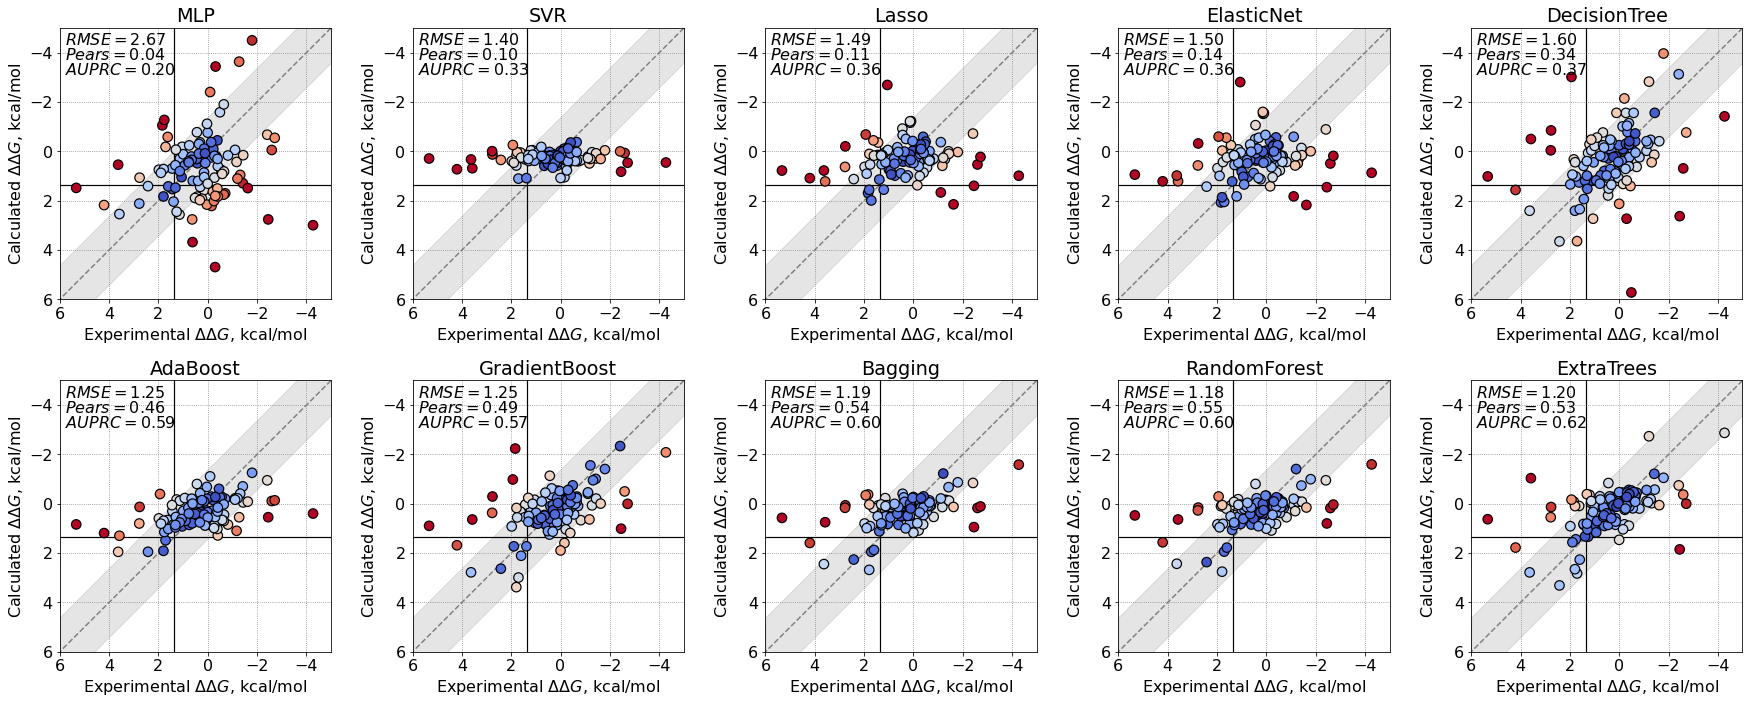

In [37]:
# plot 2. Scatter plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S2.1-multiple_randomsplit_scattorplot.pdf"))

____
#### Scenario 2.2: 5-fold cross-validation (multiple substitution). 
All data is randomly split into 5 folds, and then the machine learning method is trained on the 4 folds, while one fold is left to test the model. This process is repeated 5 times.
____

In [4]:
# select single substitution samples
mut_type = "Multiple Substitution"
mdrdb_multiple = mdrdb_coreset[mdrdb_coreset["TYPE"] == mut_type].reset_index(drop=True)
print(f"Number of samples in {mut_type} of MdrDBCoreset: {mdrdb_multiple.shape[0]}")

y = mdrdb_multiple["DDG.EXP"]
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']
X = mdrdb_multiple.drop(todrop, axis=1)
X = X.astype(float)

Number of samples in Multiple Substitution of MdrDBCoreset: 539


In [5]:
# 5-fold cross-validation
result_dict = {}
result_dict['label_true'] = y

# Set the seed for reproducibility
seed = random.randint(0, 100) 
np.random.seed(seed)

# record results
rmse_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    
for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model)    
    
    # create a KFold object with 5 folds and set the seed
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=seed)
    
    # Perform 5-fold cross validation using RMSE as the metric
    rmse_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_rmse))
    pearson_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_pearson))
    auprc_scores = cross_val_score(method, X, y, cv=kf, scoring=make_scorer(get_auc_prc))
    
    result_dict[model] = cross_val_predict(method, X, y, cv=kf)
    
    # print the mean RMSE score and its standard deviation
    log_message("Mean RMSE score: {:.2f}".format(rmse_scores.mean()))
    log_message("RMSE standard deviation: {:.2f}".format(rmse_scores.std()))
    
    rmse_dict[model].append(rmse_scores)
    pears_dict[model].append(pearson_scores)
    prc_dict[model].append(auprc_scores)

[2023-04-23 14:57:56] ---current model is: DecisionTree---
[2023-04-23 14:57:56] Mean RMSE score: 1.53
[2023-04-23 14:57:56] RMSE standard deviation: 0.14
[2023-04-23 14:57:56] ---current model is: RandomForest---
[2023-04-23 14:58:38] Mean RMSE score: 1.12
[2023-04-23 14:58:38] RMSE standard deviation: 0.15
[2023-04-23 14:58:38] ---current model is: ExtraTrees---
[2023-04-23 14:59:00] Mean RMSE score: 1.08
[2023-04-23 14:59:00] RMSE standard deviation: 0.16
[2023-04-23 14:59:00] ---current model is: Bagging---
[2023-04-23 14:59:39] Mean RMSE score: 1.11
[2023-04-23 14:59:39] RMSE standard deviation: 0.15
[2023-04-23 14:59:39] ---current model is: AdaBoost---
[2023-04-23 15:00:35] Mean RMSE score: 1.20
[2023-04-23 15:00:35] RMSE standard deviation: 0.13
[2023-04-23 15:00:35] ---current model is: GradientBoost---
[2023-04-23 15:01:53] Mean RMSE score: 1.16
[2023-04-23 15:01:53] RMSE standard deviation: 0.15
[2023-04-23 15:01:53] ---current model is: SVR---
[2023-04-23 15:01:54] Mean RMS

In [6]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by='RMSE_avg', ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  Pearson_avg  Pearson_std  AUPRC_avg  \
9            MLP     2.333     0.562        0.151        0.095      0.196   
0   DecisionTree     1.529     0.141        0.283        0.088      0.395   
6            SVR     1.295     0.150        0.198        0.050      0.341   
7     ElasticNet     1.286     0.125        0.281        0.041      0.356   
8          Lasso     1.278     0.127        0.275        0.046      0.365   
4       AdaBoost     1.202     0.132        0.412        0.068      0.482   
5  GradientBoost     1.162     0.146        0.493        0.068      0.543   
1   RandomForest     1.116     0.148        0.526        0.061      0.569   
3        Bagging     1.115     0.152        0.537        0.053      0.583   
2     ExtraTrees     1.081     0.163        0.566        0.078      0.643   

   AUPRC_std  
9      0.070  
0      0.093  
6      0.059  
7      0.042  
8      0.052  
4      0.087  
5      0.025  
1      0.021  
3      0.032  
2      0.122

In [78]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S2.2-multiple_5foldcv_ddG.pkl"
save_perf = "S2.2-multiple_5foldcv_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

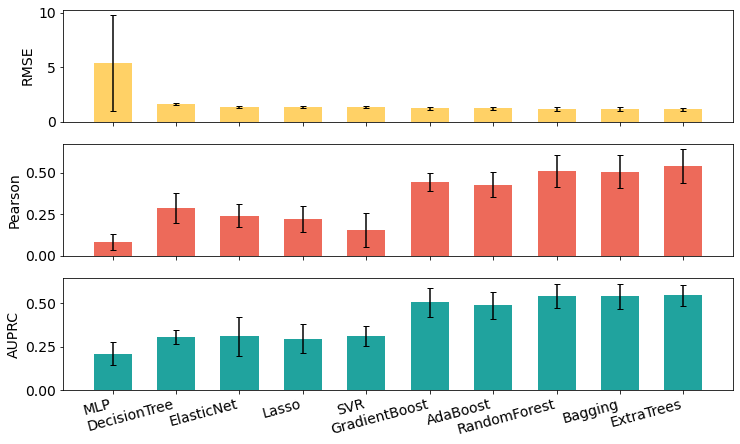

In [79]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson_sorted = result_perf["Pearson_avg"].to_list()
pearson_err_sorted = result_perf["Pearson_std"].to_list()
auprc_sorted = result_perf["AUPRC_avg"].to_list()
auprc_err_sorted = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(rmse)[::-1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S2.2-multiple_5foldcv_barplot.pdf"))
plt.show()

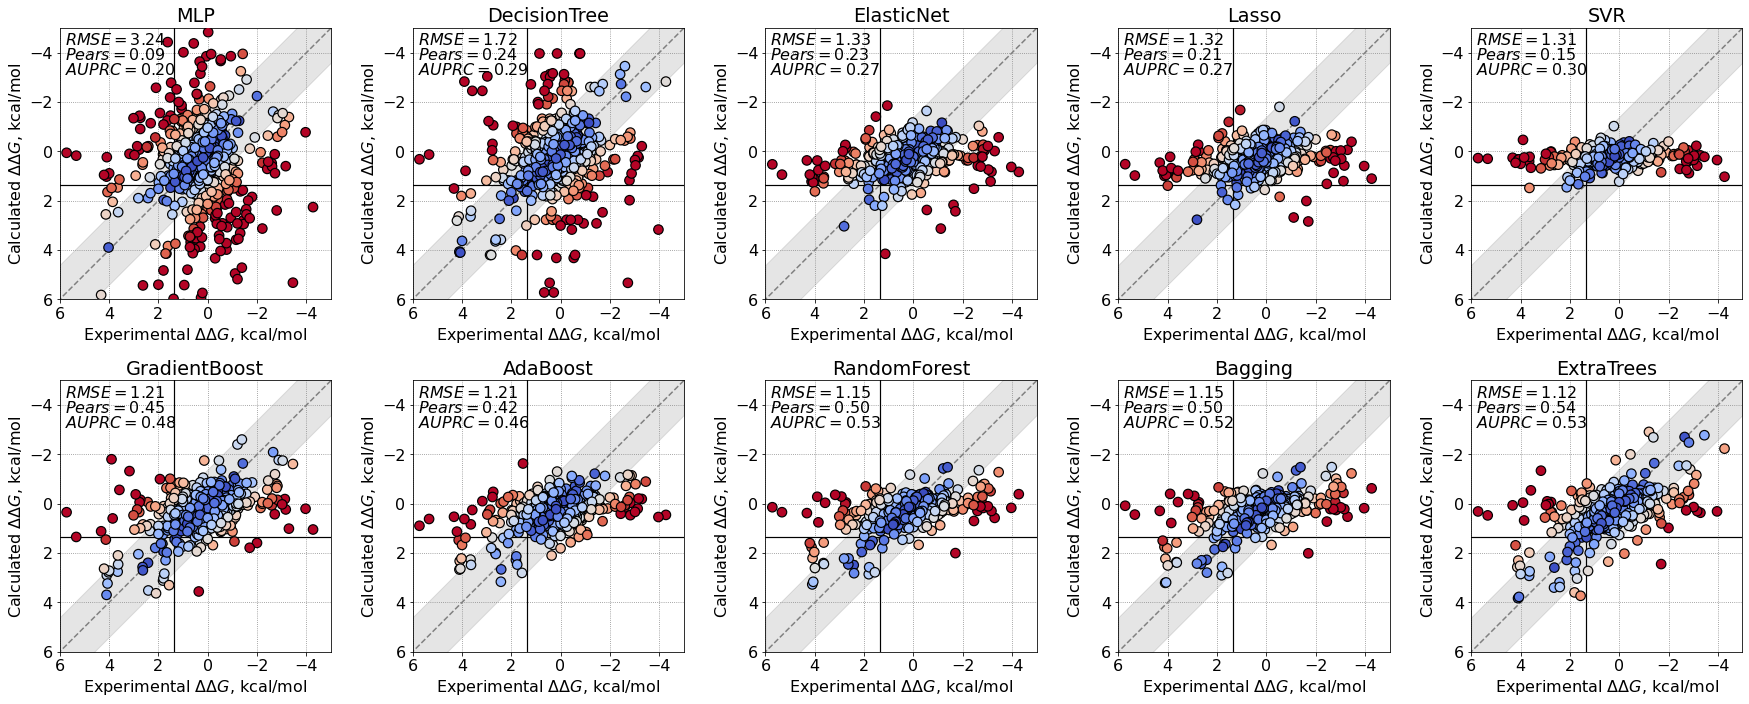

In [80]:
# plot 2. Scatter plot
# Reorder the columns
columns_name = np.insert(x_sorted, 0, "label_true")
result_ddg_new = result_ddg.reindex(columns=columns_name)


fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    ax.set_yticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S2.2-multiple_5foldcv_scatterplot.pdf"))
plt.show()

___
### Scenario 3: Evaluate the prediction performance of the machine learning methods on the MdrDB_Coreset. The models are trained on the single substitution samples and tested on the multiple substitution/deletion mutation samples.
___
#### Scenario 3.1 single-multiple
___

In [81]:
# according to the mutation type to split samples
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Single Substitution"].reset_index(drop=True)
mdrdb_multiple = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Multiple Substitution"].reset_index(drop=True)
mdrdb_deletion = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Deletion"].reset_index(drop=True)
mdrdb_indel = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Indel"].reset_index(drop=True)
mdrdb_insertion = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Insertion"].reset_index(drop=True)
mdrdb_complex = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Multiple Complex"].reset_index(drop=True)

print(f"Number of single substitution: {mdrdb_single.shape[0]}")
print(f"Number of multiple substitution: {mdrdb_multiple.shape[0]}")
print(f"Number of deletion: {mdrdb_deletion.shape[0]}")
print(f"Number of indel: {mdrdb_indel.shape[0]}")
print(f"Number of insertion: {mdrdb_insertion.shape[0]}")
print(f"Number of complex: {mdrdb_complex.shape[0]}")

Number of single substitution: 3697
Number of multiple substitution: 539
Number of deletion: 34
Number of indel: 4
Number of insertion: 8
Number of complex: 10


In [82]:
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']

y_single = mdrdb_single["DDG.EXP"]
X_single = mdrdb_single.drop(todrop, axis=1)

y_multiple = mdrdb_multiple["DDG.EXP"]
X_multiple = mdrdb_multiple.drop(todrop, axis=1)

y_deletion = mdrdb_deletion["DDG.EXP"]
X_deletion = mdrdb_deletion.drop(todrop, axis=1)

y_indel = mdrdb_indel["DDG.EXP"]
X_indel = mdrdb_indel.drop(todrop, axis=1)

y_insertion = mdrdb_insertion["DDG.EXP"]
X_insertion = mdrdb_insertion.drop(todrop, axis=1)

y_complex = mdrdb_complex["DDG.EXP"]
X_complex = mdrdb_complex.drop(todrop, axis=1)

In [83]:
# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

# model
models_list = ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'GradientBoost', 'SVR', 'ElasticNet', 'Lasso', 'MLP']
print(f"Number of models: {len(models_list)}")

X_train = X_single
y_train = y_single
X_test = X_multiple
y_test = y_multiple

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model)
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    
    
    # record the predicted results
    col_name = f'{model}'
    result_dict[f"true_label"] = np.array(y_test.to_list())
    result_dict[col_name] = y_pred
    
    # performance
    RMSE = get_rmse(y_test, y_pred)
    MAE = get_mae(y_test, y_pred)
    R2 = get_R2(y_test, y_pred)
    Pears = get_pearson(y_test, y_pred)
    PRC = get_auc_prc(y_test, y_pred)
    
    log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
    
    rmse_dict[model] = RMSE
    mae_dict[model] = MAE
    r2_dict[model] = R2
    pears_dict[model] = Pears
    prc_dict[model] = PRC

Number of models: 10
[2023-04-21 19:13:20] ---current model is: DecisionTree---
[2023-04-21 19:13:21] RMSE: 2.517; MAE: 1.7978; R2: -2.6129; Pears: 0.041; PRC: 0.1696
[2023-04-21 19:13:21] ---current model is: RandomForest---
[2023-04-21 19:13:44] RMSE: 1.4975; MAE: 1.1059; R2: -0.2788; Pears: 0.046; PRC: 0.2668
[2023-04-21 19:13:44] ---current model is: ExtraTrees---
[2023-04-21 19:13:52] RMSE: 1.292; MAE: 0.9493; R2: 0.0481; Pears: 0.272; PRC: 0.3372
[2023-04-21 19:13:52] ---current model is: Bagging---
[2023-04-21 19:14:14] RMSE: 1.4871; MAE: 1.0914; R2: -0.2613; Pears: 0.0499; PRC: 0.2568
[2023-04-21 19:14:14] ---current model is: AdaBoost---
[2023-04-21 19:14:29] RMSE: 1.4687; MAE: 1.0884; R2: -0.2302; Pears: 0.0308; PRC: 0.1754
[2023-04-21 19:14:29] ---current model is: GradientBoost---
[2023-04-21 19:15:12] RMSE: 1.5908; MAE: 1.1691; R2: -0.4432; Pears: 0.1206; PRC: 0.2736
[2023-04-21 19:15:12] ---current model is: SVR---
[2023-04-21 19:15:14] RMSE: 1.3307; MAE: 0.97; R2: -0.009

In [84]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE', 'MAE', 'R2', 'Pearson', 'AUPRC'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, rmse_dict[model], mae_dict[model], r2_dict[model], pears_dict[model], prc_dict[model]]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE", ascending=False)
results_sorted

Methods   RMSE    MAE      R2  Pearson  AUPRC
9            MLP  7.119  2.184 -27.901   -0.018  0.178
0   DecisionTree  2.517  1.798  -2.613    0.041  0.170
5  GradientBoost  1.591  1.169  -0.443    0.121  0.274
1   RandomForest  1.497  1.106  -0.279    0.046  0.267
3        Bagging  1.487  1.091  -0.261    0.050  0.257
4       AdaBoost  1.469  1.088  -0.230    0.031  0.175
6            SVR  1.331  0.970  -0.010    0.067  0.164
7     ElasticNet  1.327  0.963  -0.004    0.132  0.180
8          Lasso  1.324  0.955   0.001    0.120  0.166
2     ExtraTrees  1.292  0.949   0.048    0.272  0.337

In [85]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S3.1-single_multiple_ddG.pkl"
save_perf = "S3.1-single_multiple_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

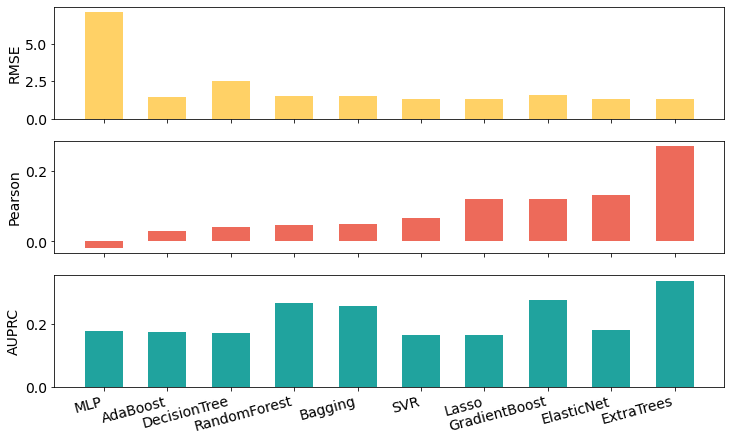

In [86]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE"].to_list()
pearson = result_perf["Pearson"].to_list()
auprc = result_perf["AUPRC"].to_list()

# Sorting the methods according to the Pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
auprc_sorted = np.array([auprc[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S3.1-single_multiple_barplot.pdf"))
plt.show()

In [87]:
# set the index of columns
columns_list = result_perf["Methods"].to_list()
columns_list = np.insert(columns_list, 0, "true_label")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_list)

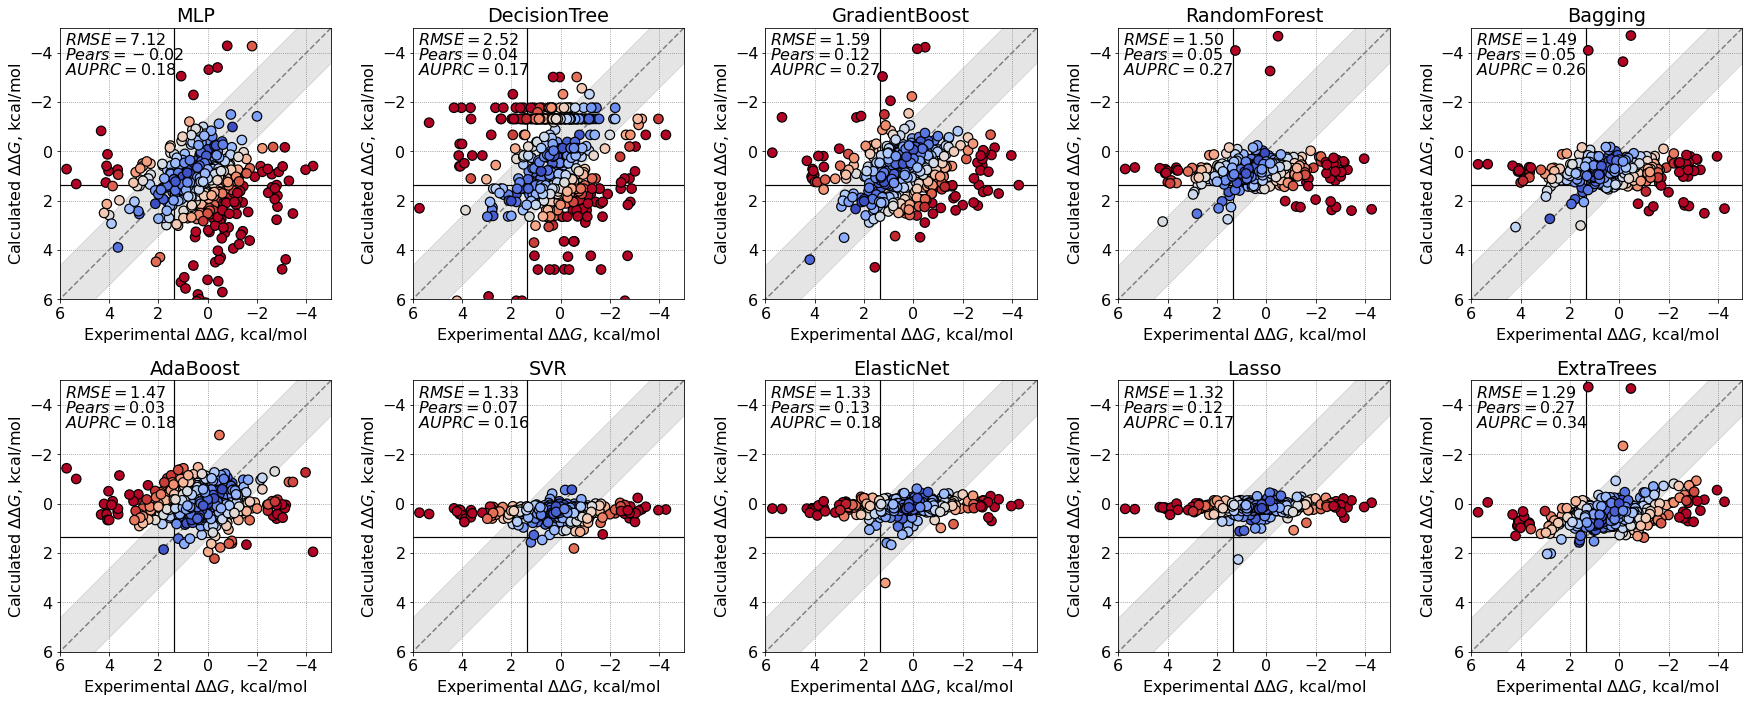

In [88]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S3.1-single_multiple_scattorplot.pdf"))

___
#### Scenario 3.2 single-deletion
___

In [89]:
# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}

# model
models_list = ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'GradientBoost', 'SVR', 'ElasticNet', 'Lasso', 'MLP']
print(f"Number of models: {len(models_list)}")

X_train = X_single
y_train = y_single
X_test = X_deletion
y_test = y_deletion

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model)
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    
    
    # record the predicted results
    col_name = f'{model}'
    result_dict[f"true_label"] = np.array(y_test.to_list())
    result_dict[col_name] = y_pred
    
    # performance
    RMSE = get_rmse(y_test, y_pred)
    MAE = get_mae(y_test, y_pred)
    R2 = get_R2(y_test, y_pred)
    Pears = get_pearson(y_test, y_pred)
    
    log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
    
    rmse_dict[model] = RMSE
    mae_dict[model] = MAE
    r2_dict[model] = R2
    pears_dict[model] = Pears

Number of models: 10
[2023-04-21 19:15:21] ---current model is: DecisionTree---
[2023-04-21 19:15:22] RMSE: 2.2107; MAE: 1.8956; R2: -6.0334; Pears: -0.2142; PRC: 0.1775
[2023-04-21 19:15:22] ---current model is: RandomForest---
[2023-04-21 19:15:45] RMSE: 1.2253; MAE: 0.9694; R2: -1.1608; Pears: 0.261; PRC: 0.1775
[2023-04-21 19:15:45] ---current model is: ExtraTrees---
[2023-04-21 19:15:52] RMSE: 0.8826; MAE: 0.6879; R2: -0.1212; Pears: 0.5005; PRC: 0.1775
[2023-04-21 19:15:52] ---current model is: Bagging---
[2023-04-21 19:16:15] RMSE: 1.1543; MAE: 0.8871; R2: -0.9175; Pears: 0.2343; PRC: 0.1775
[2023-04-21 19:16:15] ---current model is: AdaBoost---
[2023-04-21 19:16:30] RMSE: 0.8666; MAE: 0.5988; R2: -0.0809; Pears: 0.19; PRC: 0.1775
[2023-04-21 19:16:30] ---current model is: GradientBoost---
[2023-04-21 19:17:13] RMSE: 1.1113; MAE: 0.8835; R2: -0.7774; Pears: 0.4072; PRC: 0.1775
[2023-04-21 19:17:13] ---current model is: SVR---
[2023-04-21 19:17:14] RMSE: 1.2382; MAE: 0.943; R2: -

In [90]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE', 'MAE', 'R2', 'Pearson'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, rmse_dict[model], mae_dict[model], r2_dict[model], pears_dict[model]]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE", ascending=False)
results_sorted

Methods   RMSE    MAE      R2  Pearson
9            MLP  3.079  2.465 -12.645   -0.145
0   DecisionTree  2.211  1.896  -6.033   -0.214
6            SVR  1.238  0.943  -1.206   -0.217
1   RandomForest  1.225  0.969  -1.161    0.261
3        Bagging  1.154  0.887  -0.917    0.234
5  GradientBoost  1.111  0.883  -0.777    0.407
8          Lasso  1.032  0.715  -0.533    0.367
7     ElasticNet  1.017  0.719  -0.488    0.377
2     ExtraTrees  0.883  0.688  -0.121    0.500
4       AdaBoost  0.867  0.599  -0.081    0.190

In [91]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S3.2-single_deletion_ddG.pkl"
save_perf = "S3.2-single_deletion_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

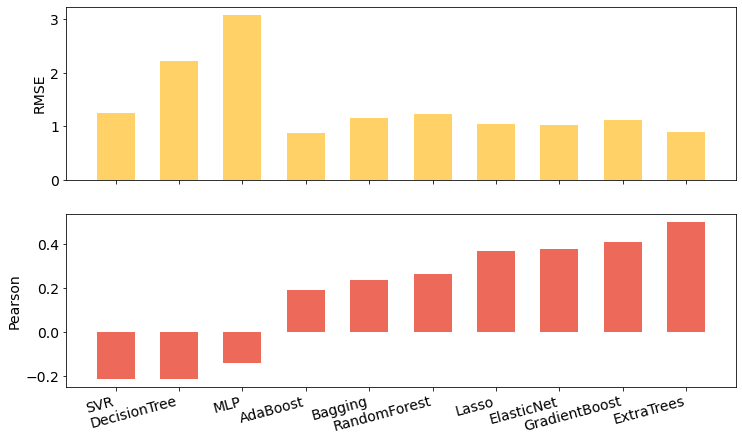

In [92]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE"].to_list()
pearson = result_perf["Pearson"].to_list()

# Sorting the methods according to the Pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')

ax[1].set_xticks(x_value)
ax[1].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S3.2-single_deletion_barplot.pdf"))
plt.show()

In [93]:
# set the index of columns
columns_list = result_perf["Methods"].to_list()
columns_list = np.insert(columns_list, 0, "true_label")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_list)

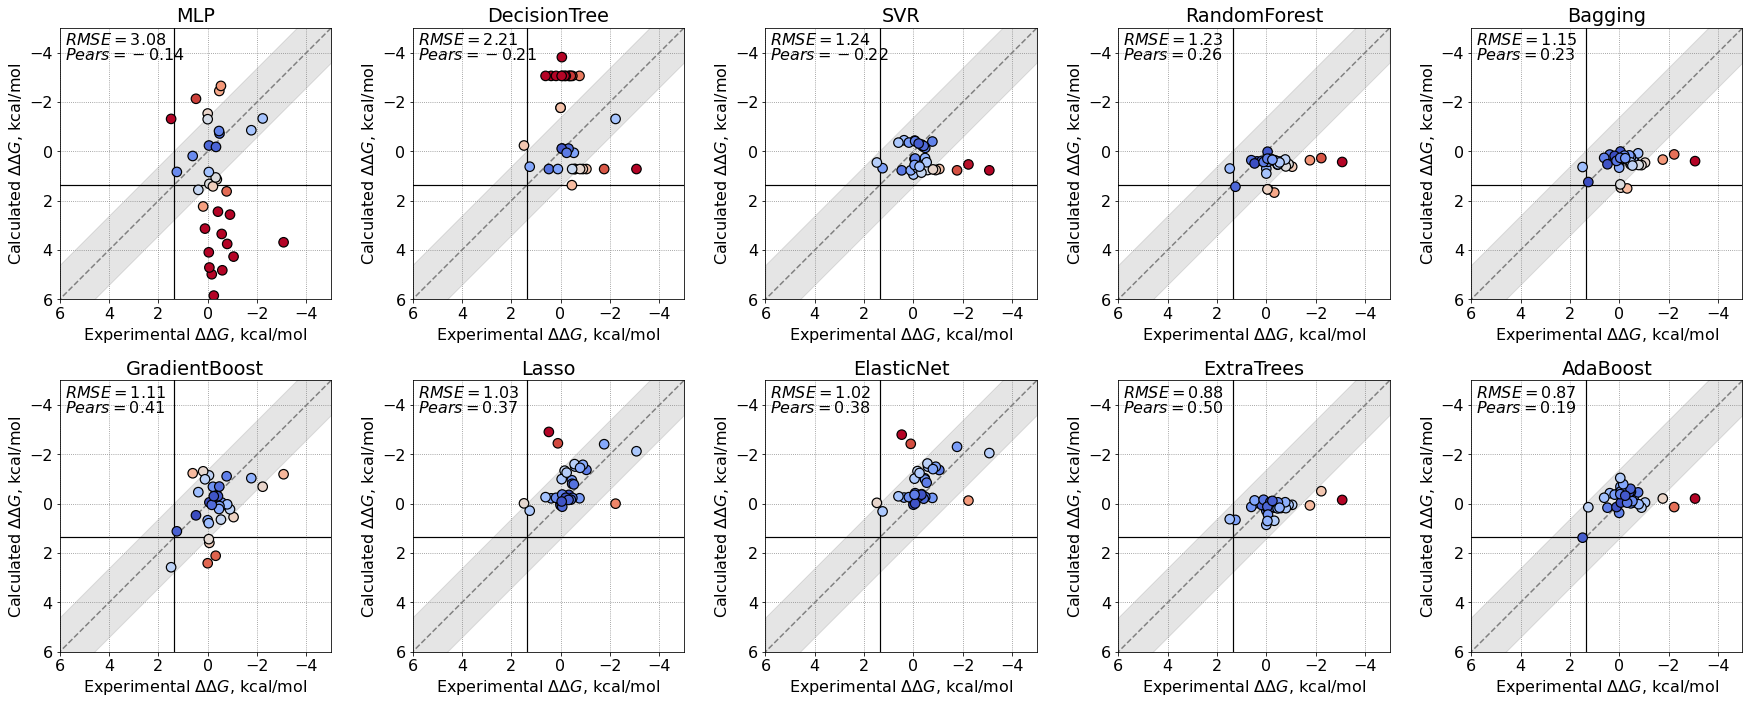

In [94]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)

    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S3.2-single_deletion_scattorplot.pdf"))

___
#### Scenario 3.3 single-(deletion+indel+insertion+complex) 
___

In [95]:
X_new = pd.concat([X_deletion, X_indel, X_insertion, X_complex], axis=0)
y_new = pd.concat([y_deletion, y_indel, y_insertion, y_complex], axis=0)

In [96]:
# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}

# model
models_list = ['DecisionTree', 'RandomForest', 'ExtraTrees', 'Bagging', 'AdaBoost', 'GradientBoost', 'SVR', 'ElasticNet', 'Lasso', 'MLP']
print(f"Number of models: {len(models_list)}")

X_train = X_single
y_train = y_single
X_test = X_new
y_test = y_new

for model in models_list:
    log_message(f"---current model is: {model}---")
    method = InstantiationModel(model)
    method.fit(X_train, y_train)
    y_pred = method.predict(X_test)
    
    
    # record the predicted results
    col_name = f'{model}'
    result_dict[f"true_label"] = np.array(y_test.to_list())
    result_dict[col_name] = y_pred
    
    # performance
    RMSE = get_rmse(y_test, y_pred)
    MAE = get_mae(y_test, y_pred)
    R2 = get_R2(y_test, y_pred)
    Pears = get_pearson(y_test, y_pred)
    
    log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
    
    rmse_dict[model] = RMSE
    mae_dict[model] = MAE
    r2_dict[model] = R2
    pears_dict[model] = Pears

Number of models: 10
[2023-04-21 19:17:20] ---current model is: DecisionTree---
[2023-04-21 19:17:21] RMSE: 2.8003; MAE: 2.1461; R2: -3.6205; Pears: -0.1964; PRC: 0.1775
[2023-04-21 19:17:21] ---current model is: RandomForest---
[2023-04-21 19:17:44] RMSE: 1.9901; MAE: 1.441; R2: -1.3335; Pears: -0.0856; PRC: 0.1775
[2023-04-21 19:17:44] ---current model is: ExtraTrees---
[2023-04-21 19:17:51] RMSE: 1.6086; MAE: 1.0818; R2: -0.5247; Pears: 0.1361; PRC: 0.1775
[2023-04-21 19:17:51] ---current model is: Bagging---
[2023-04-21 19:18:14] RMSE: 1.9941; MAE: 1.4248; R2: -1.343; Pears: -0.1119; PRC: 0.1775
[2023-04-21 19:18:14] ---current model is: AdaBoost---
[2023-04-21 19:18:29] RMSE: 1.3745; MAE: 0.9471; R2: -0.1132; Pears: 0.2609; PRC: 0.1775
[2023-04-21 19:18:29] ---current model is: GradientBoost---
[2023-04-21 19:19:12] RMSE: 1.6537; MAE: 1.164; R2: -0.6114; Pears: 0.0947; PRC: 0.1775
[2023-04-21 19:19:12] ---current model is: SVR---
[2023-04-21 19:19:13] RMSE: 1.8106; MAE: 1.3248; R2

In [97]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE', 'MAE', 'R2', 'Pearson'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, rmse_dict[model], mae_dict[model], r2_dict[model], pears_dict[model]]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE", ascending=False)
results_sorted

Methods    RMSE     MAE       R2  Pearson
9            MLP  17.754  12.726 -184.727    0.137
0   DecisionTree   2.800   2.146   -3.620   -0.196
3        Bagging   1.994   1.425   -1.343   -0.112
1   RandomForest   1.990   1.441   -1.333   -0.086
6            SVR   1.811   1.325   -0.932   -0.179
5  GradientBoost   1.654   1.164   -0.611    0.095
8          Lasso   1.641   1.232   -0.587    0.036
7     ElasticNet   1.620   1.227   -0.546    0.039
2     ExtraTrees   1.609   1.082   -0.525    0.136
4       AdaBoost   1.375   0.947   -0.113    0.261

In [98]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S3.3-single_mix_ddG.pkl"
save_perf = "S3.3-single_mix_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

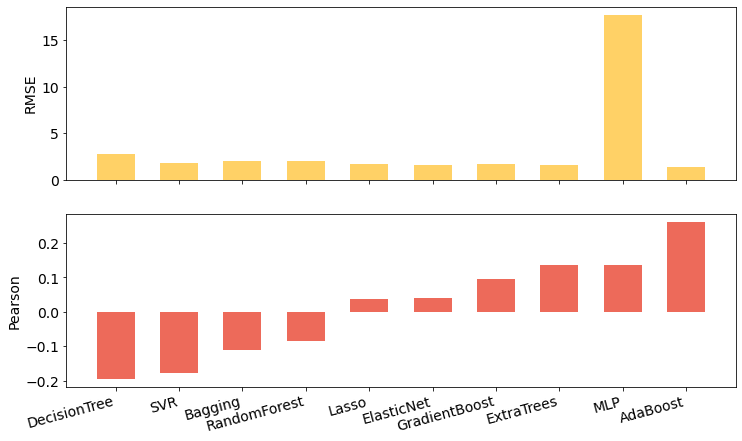

In [99]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE"].to_list()
pearson = result_perf["Pearson"].to_list()

# Sorting the methods according to the Pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')

ax[1].set_xticks(x_value)
ax[1].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S3.3-single_mix_barplot.pdf"))
plt.show()

In [100]:
# set the index of columns
columns_list = result_perf["Methods"].to_list()
columns_list = np.insert(columns_list, 0, "true_label")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_list)

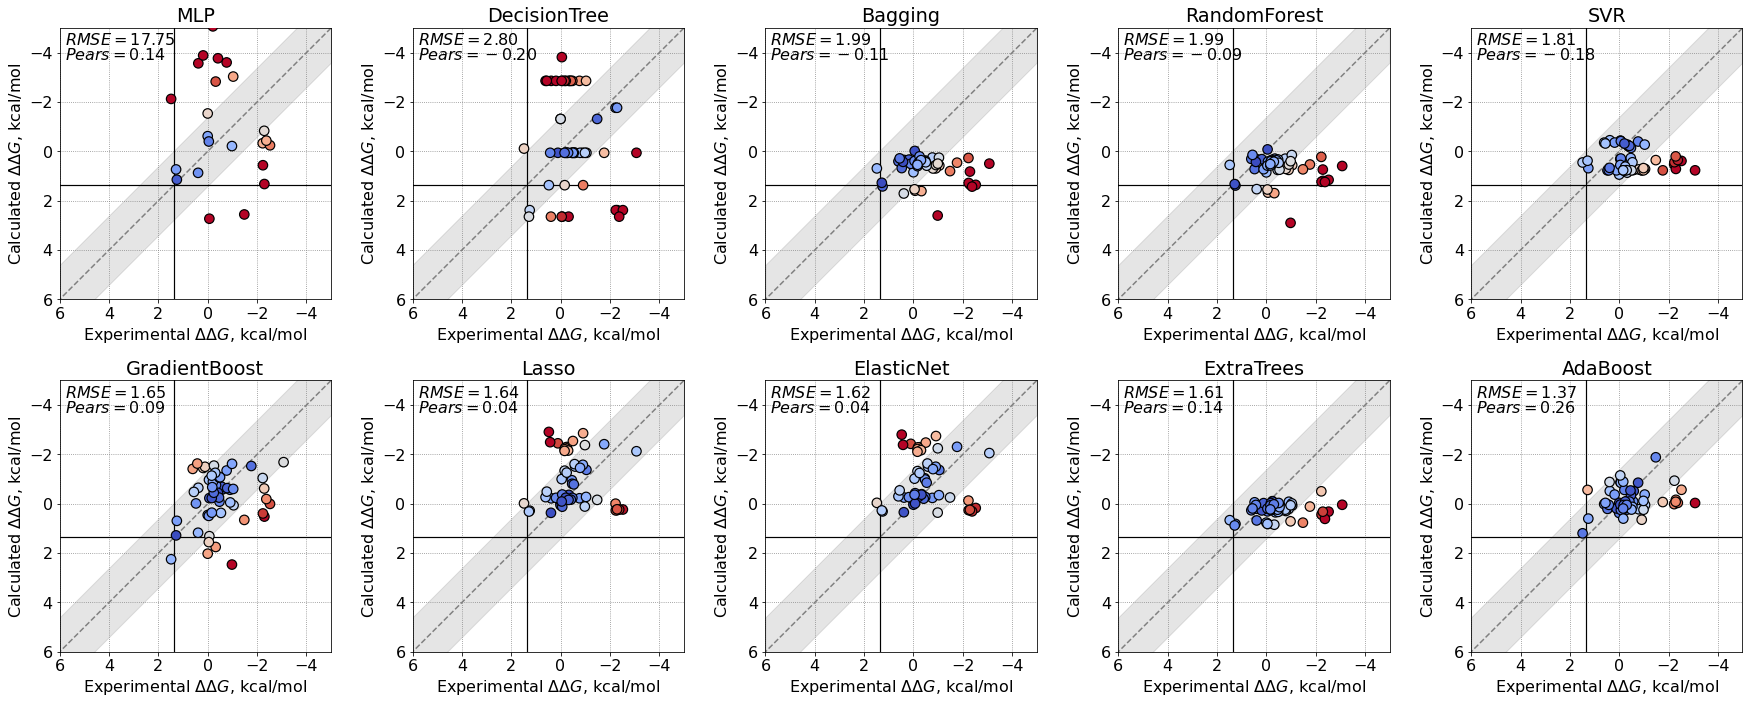

In [101]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S3.3-single_mix_scattorplot.pdf"))

___
### Scenario 4: Evaluate the prediction performance of the machine learning methods on the MdrDB_Coreset. The models are trained on the single substitution samples, fine-tuned on 80% of the data from multiple substitution/deletion mutation, and tested on the remaining 20% of the multiple substitution/deletion mutation data.
___
#### Scenario 4.1 single-multiple
___

In [102]:
# according to the mutation type to split samples
mdrdb_single = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Single Substitution"].reset_index(drop=True)
mdrdb_multiple = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Multiple Substitution"].reset_index(drop=True)
mdrdb_deletion = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Deletion"].reset_index(drop=True)
mdrdb_indel = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Indel"].reset_index(drop=True)
mdrdb_insertion = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Insertion"].reset_index(drop=True)
mdrdb_complex = mdrdb_coreset[mdrdb_coreset["TYPE"] == "Multiple Complex"].reset_index(drop=True)

print(f"Number of single substitution: {mdrdb_single.shape[0]}")
print(f"Number of multiple substitution: {mdrdb_multiple.shape[0]}")
print(f"Number of deletion: {mdrdb_deletion.shape[0]}")
print(f"Number of indel: {mdrdb_indel.shape[0]}")
print(f"Number of insertion: {mdrdb_insertion.shape[0]}")
print(f"Number of complex: {mdrdb_complex.shape[0]}")

Number of single substitution: 3697
Number of multiple substitution: 539
Number of deletion: 34
Number of indel: 4
Number of insertion: 8
Number of complex: 10


In [103]:
todrop = ["SAMPLE_ID", 'VERSION', 'TYPE', 'UNIPROT_ID', 'SAMPLE_PDB_ID', 'MUTATION', 'DRUG', 'SMILES', 'PROTEIN_NAME', 
          'PROTEIN_FAMILY', 'PROTEIN_SUPERFAMILY', 'PROTEIN_DOMAIN', 'CID', 'FDA_MECHANISM', 'MESH', 'DRUG_CLASSES', 'DDG.EXP', 
          'SAMPLE_SOURCE', 'MUTATION_SOURCE', 'DRUG_POSE_SOURCE','DATASET']

y_single = mdrdb_single["DDG.EXP"]
X_single = mdrdb_single.drop(todrop, axis=1)

y_multiple = mdrdb_multiple["DDG.EXP"]
X_multiple = mdrdb_multiple.drop(todrop, axis=1)

y_deletion = mdrdb_deletion["DDG.EXP"]
X_deletion = mdrdb_deletion.drop(todrop, axis=1)

y_indel = mdrdb_indel["DDG.EXP"]
X_indel = mdrdb_indel.drop(todrop, axis=1)

y_insertion = mdrdb_insertion["DDG.EXP"]
X_insertion = mdrdb_insertion.drop(todrop, axis=1)

y_complex = mdrdb_complex["DDG.EXP"]
X_complex = mdrdb_complex.drop(todrop, axis=1)

In [104]:
# set the single substitution samples as the training set
X_train = X_single
y_train = y_single

# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    mae_dict[model] = []
    r2_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = []
result_dict["label_true"] = []

for iteration in range(iterations):
    # randomly select 80% of the samples from the multiple substitution as the fine-tuning set
    seed = random.randint(0, 100)
    np.random.seed(seed)
    log_message(f"random sampling samples with seed {seed}...")
    X_fine_tune, X_test, y_fine_tune, y_test = train_test_split(X_multiple, y_multiple, test_size=0.2, random_state=seed)
    
    y_exp = np.array(y_test.to_list())
    result_dict["label_true"].extend(y_exp)
    
    for model in models_list:
        log_message(f"---current model is: {model}---")
        
        # Create and train the initial model on the training set
        method = InstantiationModel(model)
        method.fit(X_train, y_train)  

        # Fine-tune the model on the fine-tuning set
        method.set_params() # For example, changing hyperparameters
        method.fit(X_fine_tune, y_fine_tune)
        
        # Test the final model on the test set
        y_pred = method.predict(X_test)
        
        # record the predicted results
        result_dict[model].extend(y_pred)
        
        # performance
        RMSE = get_rmse(y_test, y_pred)
        MAE = get_mae(y_test, y_pred)
        R2 = get_R2(y_test, y_pred)
        Pears = get_pearson(y_test, y_pred)
        PRC = get_auc_prc(y_test, y_pred)
        
        log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}; PRC: {round(PRC, 4)}")
        
        rmse_dict[model].append(RMSE)
        mae_dict[model].append(MAE)
        r2_dict[model].append(R2)
        pears_dict[model].append(Pears)
        prc_dict[model].append(PRC)
    log_message(f"Finish the {iteration}-th iteration!")

[2023-04-21 19:19:22] random sampling samples with seed 29...
[2023-04-21 19:19:22] ---current model is: DecisionTree---
[2023-04-21 19:19:23] RMSE: 1.5697; MAE: 1.1688; R2: -0.1549; Pears: 0.4078; PRC: 0.3013
[2023-04-21 19:19:23] ---current model is: RandomForest---
[2023-04-21 19:19:48] RMSE: 1.1946; MAE: 0.8813; R2: 0.3311; Pears: 0.6043; PRC: 0.5361
[2023-04-21 19:19:48] ---current model is: ExtraTrees---
[2023-04-21 19:19:56] RMSE: 1.081; MAE: 0.7807; R2: 0.4523; Pears: 0.6846; PRC: 0.6044
[2023-04-21 19:19:56] ---current model is: Bagging---
[2023-04-21 19:20:21] RMSE: 1.1905; MAE: 0.8784; R2: 0.3357; Pears: 0.6076; PRC: 0.5153
[2023-04-21 19:20:21] ---current model is: AdaBoost---
[2023-04-21 19:20:38] RMSE: 1.2474; MAE: 0.955; R2: 0.2706; Pears: 0.529; PRC: 0.5799
[2023-04-21 19:20:38] ---current model is: GradientBoost---
[2023-04-21 19:21:25] RMSE: 1.2166; MAE: 0.8828; R2: 0.3062; Pears: 0.5633; PRC: 0.5223
[2023-04-21 19:21:25] ---current model is: SVR---
[2023-04-21 19:21:

In [105]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std', 'AUPRC_avg', 'AUPRC_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(mae_dict[model]), np.std(mae_dict[model]), 
                            np.mean(r2_dict[model]), np.std(r2_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model]), 
                            np.mean(prc_dict[model]), np.std(prc_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std  R2_avg  R2_std  \
9            MLP     2.202     0.476    1.544    0.293  -1.789   1.075   
0   DecisionTree     1.548     0.128    1.103    0.126  -0.333   0.165   
7     ElasticNet     1.347     0.070    0.993    0.049  -0.008   0.040   
8          Lasso     1.331     0.076    0.987    0.049   0.016   0.038   
6            SVR     1.329     0.101    0.960    0.069   0.022   0.029   
4       AdaBoost     1.198     0.087    0.906    0.054   0.203   0.067   
5  GradientBoost     1.170     0.091    0.837    0.047   0.239   0.089   
3        Bagging     1.140     0.080    0.810    0.052   0.279   0.058   
1   RandomForest     1.132     0.085    0.804    0.056   0.288   0.063   
2     ExtraTrees     1.057     0.073    0.726    0.050   0.377   0.082   

   Pearson_avg  Pearson_std  AUPRC_avg  AUPRC_std  
9        0.158        0.111      0.180      0.076  
0        0.356        0.067      0.412      0.132  
7        0.223        0.029      0.220      0.072  
8        0.217        0.040      0.217      0.087  
6        0.159        0.072      0.265      0.144  
4        0.457        0.074      0.497      0.042  
5        0.506        0.071      0.515      0.045  
3        0.538        0.064      0.550      0.079  
1        0.550        0.069      0.566      0.069  
2        0.620        0.068      0.637      0.075

In [106]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S4.1-single_multiple_finetune_ddG.pkl"
save_perf = "S4.1-single_multiple_finetune_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

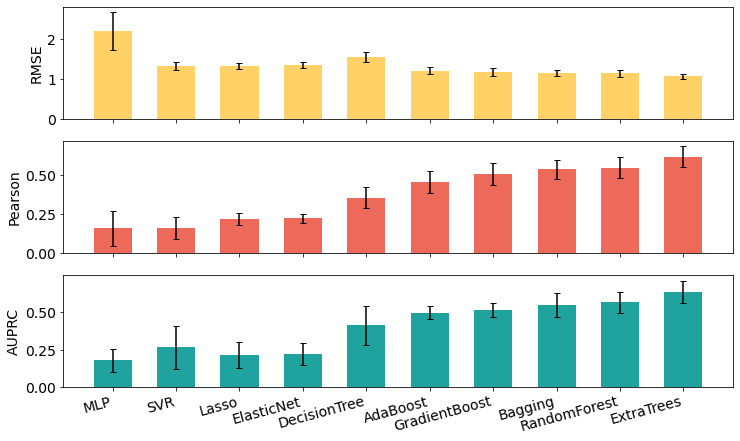

In [107]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()
auprc = result_perf["AUPRC_avg"].to_list()
auprc_err = result_perf["AUPRC_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])
auprc_sorted = np.array([auprc[i] for i in sorted_indices])
auprc_err_sorted = np.array([auprc_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])
ax[2].bar(x_value, auprc_sorted, width, color=colors[2])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[2].errorbar(x_value[i], auprc_sorted[i], yerr=auprc_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')
ax[2].set(ylabel='AUPRC')

ax[2].set_xticks(x_value)
ax[2].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S4.1-single_multiple_finetune_barplot.pdf"))
plt.show()

In [108]:
# Rename the columns
result_ddg.columns = [i for i in result_ddg.columns]
columns_name = np.insert(x_sorted, 0, "label_true")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_name)

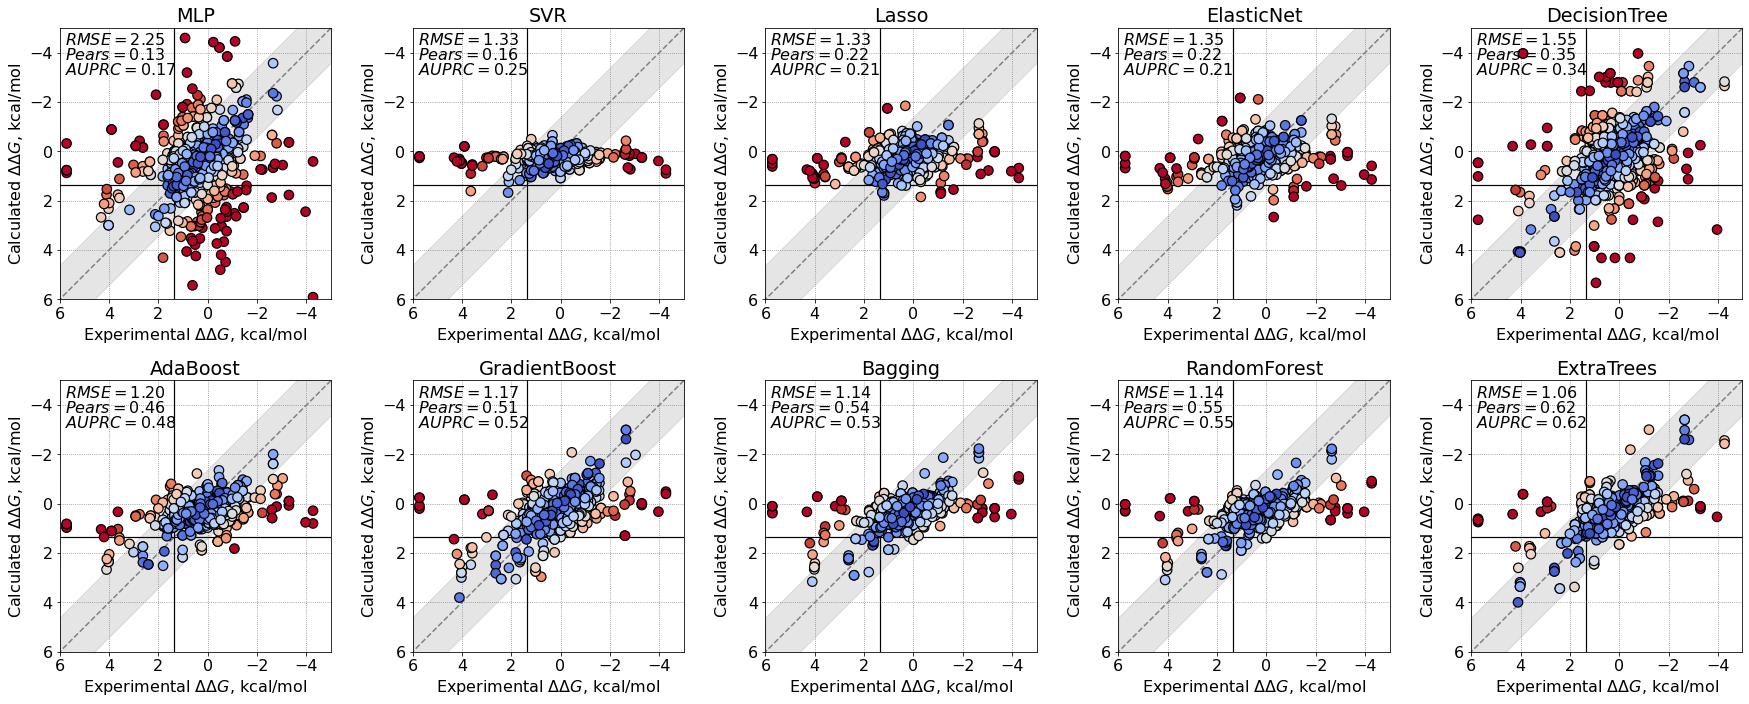

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    auprc = get_auc_prc(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    _ = ax.annotate('$AUPRC   = %.2f$' % (auprc), xy=(annx, anny-2*asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S4.1-single_multiple_finetune_scattorplot.pdf"))

___
#### Scenario 4.2 single-deletion
___

In [110]:
# set the single substitution samples as the training set
X_train = X_single
y_train = y_single

# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}
prc_dict = {}

for model in models_list:
    rmse_dict[model] = []
    mae_dict[model] = []
    r2_dict[model] = []
    pears_dict[model] = []
    prc_dict[model] = []
    result_dict[model] = []
result_dict["label_true"] = []

for iteration in range(iterations):
    # randomly select 80% of the samples from the multiple substitution as the fine-tuning set
    seed = random.randint(0, 100)
    np.random.seed(seed)
    log_message(f"random sampling samples with seed {seed}...")
    X_fine_tune, X_test, y_fine_tune, y_test = train_test_split(X_deletion, y_deletion, test_size=0.2, random_state=seed)
    
    y_exp = np.array(y_test.to_list())
    result_dict["label_true"].extend(y_exp)
    
    for model in models_list:
        log_message(f"---current model is: {model}---")
        
        # Create and train the initial model on the training set
        method = InstantiationModel(model)
        method.fit(X_train, y_train)  

        # Fine-tune the model on the fine-tuning set
        method.set_params() # For example, changing hyperparameters
        method.fit(X_fine_tune, y_fine_tune)
        
        # Test the final model on the test set
        y_pred = method.predict(X_test)
        
        # record the predicted results
        result_dict[model].extend(y_pred)
        
        # performance
        RMSE = get_rmse(y_test, y_pred)
        MAE = get_mae(y_test, y_pred)
        R2 = get_R2(y_test, y_pred)
        Pears = get_pearson(y_test, y_pred)
        
        log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}")
        
        rmse_dict[model].append(RMSE)
        mae_dict[model].append(MAE)
        r2_dict[model].append(R2)
        pears_dict[model].append(Pears)
    log_message(f"Finish the {iteration}-th iteration!")

[2023-04-21 19:30:11] random sampling samples with seed 59...
[2023-04-21 19:30:11] ---current model is: DecisionTree---
[2023-04-21 19:30:11] RMSE: 2.6049; MAE: 2.224; R2: -5.1299; Pears: -0.4952
[2023-04-21 19:30:11] ---current model is: RandomForest---
[2023-04-21 19:30:35] RMSE: 1.6493; MAE: 1.2914; R2: -1.4573; Pears: -0.0504
[2023-04-21 19:30:35] ---current model is: ExtraTrees---
[2023-04-21 19:30:43] RMSE: 1.6099; MAE: 1.1351; R2: -1.3415; Pears: 0.1899
[2023-04-21 19:30:43] ---current model is: Bagging---
[2023-04-21 19:31:06] RMSE: 1.6733; MAE: 1.3096; R2: -1.5296; Pears: -0.0162
[2023-04-21 19:31:06] ---current model is: AdaBoost---
[2023-04-21 19:31:21] RMSE: 2.3698; MAE: 1.7251; R2: -4.0734; Pears: -0.597
[2023-04-21 19:31:21] ---current model is: GradientBoost---
[2023-04-21 19:32:05] RMSE: 2.5402; MAE: 2.0525; R2: -4.8295; Pears: -0.5028
[2023-04-21 19:32:05] ---current model is: SVR---
[2023-04-21 19:32:06] RMSE: 1.0; MAE: 0.8302; R2: 0.0966; Pears: 0.8551
[2023-04-21 1

In [111]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(mae_dict[model]), np.std(mae_dict[model]), 
                            np.mean(r2_dict[model]), np.std(r2_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std   R2_avg  R2_std  \
9            MLP     7.443     5.012    5.698    4.053 -104.656  89.466   
7     ElasticNet     2.004     0.726    1.458    0.488   -7.000   8.500   
8          Lasso     1.480     0.420    1.113    0.338   -2.662   2.666   
5  GradientBoost     1.295     0.640    0.962    0.559   -1.406   1.802   
0   DecisionTree     1.265     0.731    1.014    0.633   -1.191   2.014   
4       AdaBoost     1.254     0.579    0.890    0.430   -1.194   1.519   
3        Bagging     1.152     0.293    0.846    0.247   -0.869   0.835   
1   RandomForest     1.143     0.287    0.837    0.242   -0.828   0.770   
2     ExtraTrees     1.100     0.294    0.801    0.217   -0.688   0.722   
6            SVR     0.938     0.173    0.700    0.117   -0.192   0.371   

   Pearson_avg  Pearson_std  
9        0.099        0.329  
7        0.579        0.197  
8        0.518        0.279  
5        0.016        0.425  
0        0.327        0.475  
4        0.036        0.498  
3        0.235        0.295  
1        0.231        0.325  
2        0.276        0.370  
6        0.661        0.237

In [112]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S4.2-single_deletion_finetune_ddG.pkl"
save_perf = "S4.2-single_deletion_finetune_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

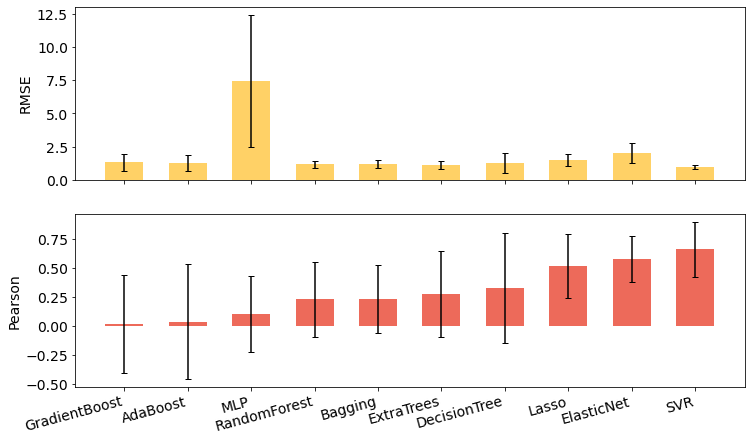

In [113]:
# plot1: bar plot
# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')

ax[1].set_xticks(x_value)
ax[1].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S4.2-single_deletion_finetune_barplot.pdf"))
plt.show()

In [114]:
# Rename the columns
result_ddg.columns = [i for i in result_ddg.columns]
columns_name = np.insert(x_sorted, 0, "label_true")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_name)

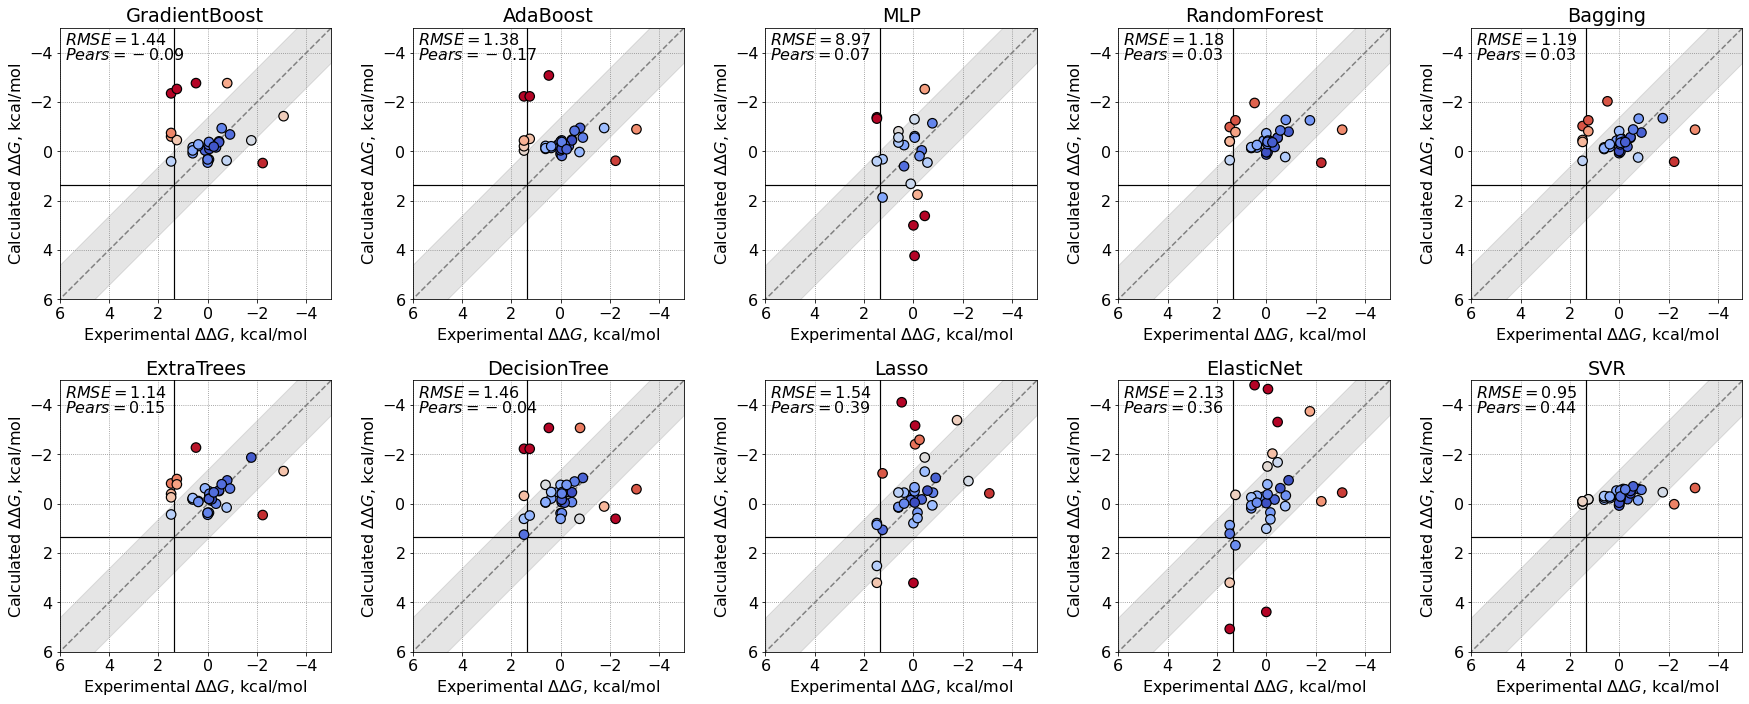

In [115]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S4.2-single_deletion_finetune_scattorplot.pdf"))

___
#### Scenario 4.3 single-(deletion+indel+insertion+complex) 
___

In [116]:
X_new = pd.concat([X_deletion, X_indel, X_insertion, X_complex], axis=0)
y_new = pd.concat([y_deletion, y_indel, y_insertion, y_complex], axis=0)

In [117]:
# set the single substitution samples as the training set
X_train = X_single
y_train = y_single

# record the results (initialization)
result_dict = {}
rmse_dict = {}
mae_dict = {}
r2_dict = {}
pears_dict = {}

for model in models_list:
    rmse_dict[model] = []
    mae_dict[model] = []
    r2_dict[model] = []
    pears_dict[model] = []
    result_dict[model] = []
result_dict["label_true"] = []

for iteration in range(iterations):
    # randomly select 80% of the samples from the multiple substitution as the fine-tuning set
    seed = random.randint(0, 100)
    np.random.seed(seed)
    log_message(f"random sampling samples with seed {seed}...")
    X_fine_tune, X_test, y_fine_tune, y_test = train_test_split(X_new, y_new, test_size=0.2, random_state=seed)
    
    y_exp = np.array(y_test.to_list())
    result_dict["label_true"].extend(y_exp)
    
    for model in models_list:
        log_message(f"---current model is: {model}---")
        
        # Create and train the initial model on the training set
        method = InstantiationModel(model)
        method.fit(X_train, y_train)  

        # Fine-tune the model on the fine-tuning set
        method.set_params() # For example, changing hyperparameters
        method.fit(X_fine_tune, y_fine_tune)
        
        # Test the final model on the test set
        y_pred = method.predict(X_test)
        
        # record the predicted results
        result_dict[model].extend(y_pred)
        
        # performance
        RMSE = get_rmse(y_test, y_pred)
        MAE = get_mae(y_test, y_pred)
        R2 = get_R2(y_test, y_pred)
        Pears = get_pearson(y_test, y_pred)
        
        log_message(f"RMSE: {round(RMSE, 4)}; MAE: {round(MAE, 4)}; R2: {round(R2, 4)}; Pears: {round(Pears, 4)}")
        
        rmse_dict[model].append(RMSE)
        mae_dict[model].append(MAE)
        r2_dict[model].append(R2)
        pears_dict[model].append(Pears)
    log_message(f"Finish the {iteration}-th iteration!")

[2023-04-21 19:40:08] random sampling samples with seed 72...
[2023-04-21 19:40:08] ---current model is: DecisionTree---
[2023-04-21 19:40:08] RMSE: 1.5968; MAE: 1.316; R2: -0.106; Pears: 0.4666
[2023-04-21 19:40:08] ---current model is: RandomForest---
[2023-04-21 19:40:32] RMSE: 1.345; MAE: 1.0154; R2: 0.2154; Pears: 0.5062
[2023-04-21 19:40:32] ---current model is: ExtraTrees---
[2023-04-21 19:40:40] RMSE: 1.4293; MAE: 1.1458; R2: 0.1139; Pears: 0.4811
[2023-04-21 19:40:40] ---current model is: Bagging---
[2023-04-21 19:41:03] RMSE: 1.3446; MAE: 1.0027; R2: 0.2157; Pears: 0.5045
[2023-04-21 19:41:03] ---current model is: AdaBoost---
[2023-04-21 19:41:19] RMSE: 1.1858; MAE: 0.8837; R2: 0.3901; Pears: 0.6639
[2023-04-21 19:41:19] ---current model is: GradientBoost---
[2023-04-21 19:42:03] RMSE: 1.3416; MAE: 0.9855; R2: 0.2193; Pears: 0.5134
[2023-04-21 19:42:03] ---current model is: SVR---
[2023-04-21 19:42:04] RMSE: 1.4752; MAE: 0.897; R2: 0.0561; Pears: 0.3215
[2023-04-21 19:42:04] 

In [129]:
# statistic the results
results = pd.DataFrame(columns=['Methods', 'RMSE_avg', 'RMSE_std', 'MAE_avg', 'MAE_std', 'R2_avg', 'R2_std', 'Pearson_avg', 'Pearson_std'])

for row_idx, model in enumerate(models_list):
    results.loc[row_idx] = [model, 
                            np.mean(rmse_dict[model]), np.std(rmse_dict[model]), 
                            np.mean(mae_dict[model]), np.std(mae_dict[model]), 
                            np.mean(r2_dict[model]), np.std(r2_dict[model]), 
                            np.mean(pears_dict[model]), np.std(pears_dict[model])]
results = results.round(3)
results_sorted = results.sort_values(by="RMSE_avg", ascending=False)
results_sorted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std  R2_avg  R2_std  \
9            MLP     4.203     1.244    2.809    0.762 -10.050   1.675   
0   DecisionTree     1.627     0.437    1.139    0.264  -1.049   1.539   
7     ElasticNet     1.577     0.164    1.224    0.091  -1.045   1.264   
8          Lasso     1.449     0.158    1.126    0.107  -0.647   0.900   
2     ExtraTrees     1.363     0.448    0.931    0.279  -0.179   0.504   
6            SVR     1.357     0.437    0.905    0.275  -0.121   0.175   
3        Bagging     1.227     0.402    0.890    0.271   0.081   0.228   
1   RandomForest     1.206     0.404    0.882    0.280   0.116   0.232   
5  GradientBoost     1.172     0.438    0.868    0.320   0.138   0.429   
4       AdaBoost     1.126     0.474    0.811    0.316   0.236   0.341   

   Pearson_avg  Pearson_std  
9       -0.006        0.497  
0        0.365        0.173  
7        0.473        0.227  
8        0.476        0.244  
2        0.254        0.319  
6       -0.005        0.241  
3        0.376        0.248  
1        0.404        0.252  
5        0.477        0.276  
4        0.540        0.319

In [130]:
save_path = "/data/yangziyi/1-PMO/6-TKI/MdrDB_CC/results"
save_ddg = "S4.3-single_mix_finetune_ddG.tsv"
save_perf = "S4.3-single_mix_finetune_perf.tsv"

if os.path.exists(os.path.join(save_path, save_ddg)) and os.path.exists(os.path.join(save_path, save_perf)):
    # load files
    result_perf = pd.read_csv(os.path.join(save_path, save_perf), sep='\t')
    result_ddg = load_obj(save_filename=save_ddg, save_path=save_path)
    
else:
    # save files
    results_sorted.to_csv(os.path.join(save_path, save_perf), sep='\t', index=None)
    save_obj(data=result_dict, save_filename=save_ddg, save_path=save_path)
    result_ddg = result_dict
    result_perf = results_sorted

result_ddg = pd.DataFrame(result_ddg)

In [131]:
results_sorted

Methods  RMSE_avg  RMSE_std  MAE_avg  MAE_std  R2_avg  R2_std  \
9            MLP     4.203     1.244    2.809    0.762 -10.050   1.675   
0   DecisionTree     1.627     0.437    1.139    0.264  -1.049   1.539   
7     ElasticNet     1.577     0.164    1.224    0.091  -1.045   1.264   
8          Lasso     1.449     0.158    1.126    0.107  -0.647   0.900   
2     ExtraTrees     1.363     0.448    0.931    0.279  -0.179   0.504   
6            SVR     1.357     0.437    0.905    0.275  -0.121   0.175   
3        Bagging     1.227     0.402    0.890    0.271   0.081   0.228   
1   RandomForest     1.206     0.404    0.882    0.280   0.116   0.232   
5  GradientBoost     1.172     0.438    0.868    0.320   0.138   0.429   
4       AdaBoost     1.126     0.474    0.811    0.316   0.236   0.341   

   Pearson_avg  Pearson_std  
9       -0.006        0.497  
0        0.365        0.173  
7        0.473        0.227  
8        0.476        0.244  
2        0.254        0.319  
6       -0.005        0.241  
3        0.376        0.248  
1        0.404        0.252  
5        0.477        0.276  
4        0.540        0.319

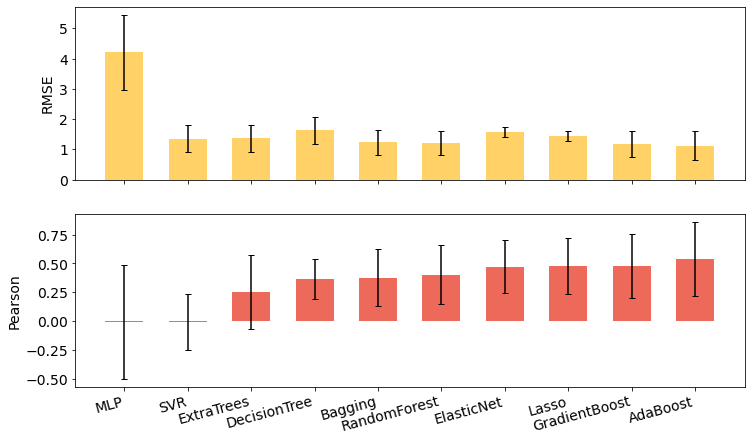

In [132]:
# plot1: bar plot

# Define the data for the bar plot and the error bars
x = result_perf["Methods"].to_list()
rmse = result_perf["RMSE_avg"].to_list()
rmse_err = result_perf["RMSE_std"].to_list()
pearson = result_perf["Pearson_avg"].to_list()
pearson_err = result_perf["Pearson_std"].to_list()

# Sorting the methods according to the pearson value
sorted_indices = np.argsort(pearson)[::1]
x_sorted = np.array([x[i] for i in sorted_indices])
rmse_sorted = np.array([rmse[i] for i in sorted_indices])
rmse_err_sorted = np.array([rmse_err[i] for i in sorted_indices])
pearson_sorted = np.array([pearson[i] for i in sorted_indices])
pearson_err_sorted = np.array([pearson_err[i] for i in sorted_indices])

# Setting the default font size
mpl.rcParams['font.size'] = 14

# Setting colors
colors = ["#ffd166", "#ed6a5a", "#20a39e"]

# Set the width of the bars
width = 0.6

# Create a bar plot
x_value = np.array([i for i in range(len(x_sorted))])
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,7), sharex=True)
ax[0].bar(x_value, rmse_sorted, width, color=colors[0])
ax[1].bar(x_value, pearson_sorted, width, color=colors[1])

# Add error bars to each bar in the plot
for i in range(len(x)):
    ax[0].errorbar(x_value[i], rmse_sorted[i], yerr=rmse_err_sorted[i], fmt='none', ecolor='black', capsize=3)
    ax[1].errorbar(x_value[i], pearson_sorted[i], yerr=pearson_err_sorted[i], fmt='none', ecolor='black', capsize=3)

# Set the title and axis labels for the plot
ax[0].set(ylabel='RMSE')
ax[1].set(ylabel='Pearson')

ax[1].set_xticks(x_value)
ax[1].set_xticklabels(x_sorted, rotation=15, ha='right')

# Display the plot
if save_file:
    plt.savefig(os.path.join(save_path, "S4.3-single_mix_finetune_barplot.pdf"))
plt.show()

In [133]:
# Rename the columns
result_ddg.columns = [i for i in result_ddg.columns]
columns_name = np.insert(x_sorted, 0, "label_true")

# Reorder the columns
result_ddg_new = result_ddg.reindex(columns=columns_name)

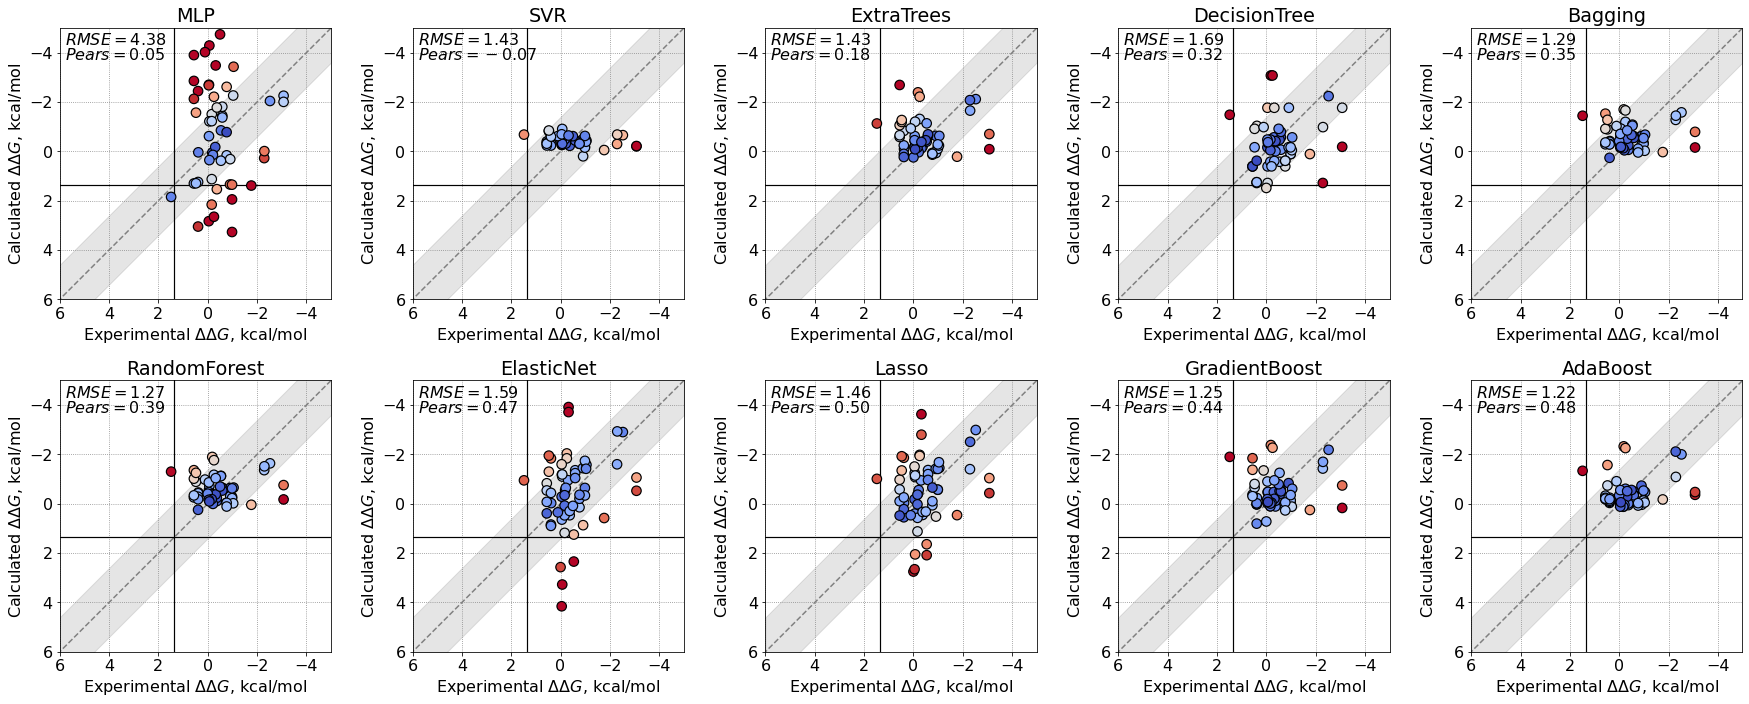

In [135]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    ddg_exp = result_ddg_new.iloc[:, 0]
    ddg_cal = result_ddg_new.iloc[:, i+1]
    
    xlim = [-5, 6]
    ylim = [-5, 6]
    
    rmse = get_rmse(ddg_exp, ddg_cal)
    pears = get_pearson(ddg_exp, ddg_cal)
    
    plot_corr(ax, ddg_exp, ddg_cal, title=result_ddg_new.columns[i+1], fit=False, xlim=xlim, ylim=ylim, colorbar=False)
    
    annx = 5.8
    anny = -4.3
    asep = -0.6
    
    _ = ax.annotate('$RMSE  = %.2f$' % (rmse), xy=(annx, anny), zorder=10, fontsize=16)
    _ = ax.annotate('$Pears = %.2f$' % (pears), xy=(annx, anny-asep), zorder=10, fontsize=16)
    
    ax.set_xticks([-4, -2, 0, 2, 4, 6])
    plt.tight_layout()
    
if save_file:
    plt.savefig(os.path.join(save_path, "S4.3-single_mix_finetune_scattorplot.pdf"))